# ***Tensorflow Architettura Base (D.A. Offline)  - A. Giacomini & D. Bernovschi***

## Setting Parametri Test (CROP e NO CROP) 

In [ ]:
#path_IMAGES = '/content/drive/MyDrive/CALCIO_CROP_BASE/'
path_IMAGES = '/content/drive/MyDrive/CALCIO_NOPRE/'

'''some useful parameters and variables'''
parte = 'CALCIO'
tipo = 'NO_CROP' #CROP, CROP_gray_ridge, NO_CROP

#Ricordati di cambiare anche gli Hyper Parameters !!!!

## IMPORT

In [ ]:
import sys
import subprocess
if 'google.colab' in sys.modules:
  subprocess.call("pip install -U progress".split())


import pandas as pd
import random
import os
import os.path
from os import path
import scipy.ndimage
import numpy as np
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import optimizers, layers
from tensorflow.keras.layers import Activation, Input, Conv2D, ZeroPadding2D, MaxPooling2D, UpSampling2D, concatenate, Flatten, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import to_categorical 
from PIL import Image, ImageOps
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score,classification_report, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import confusion_matrix
from google.colab.patches import cv2_imshow
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential, save_model, load_model
import matplotlib.pyplot as plt
import cv2
from random import randrange
print('Tensor Flow {}'.format(tf.__version__))
print('Keras {}'.format(tf.keras.__version__))


Tensor Flow 2.8.2
Keras 2.8.0


In [1]:
!python --version

Python 3.7.14


In [ ]:
'''vecchio costrutto'''
#random.seed( 40 )

'''nuovo costrutto'''
def fix_seeds(seed: int) -> None:
  """ Fix random seeds for numpy, tensorflow, random, etc.

  Parameters
  -----------
  seed : int.
  Random seed.
  """

  np.random.seed(seed) # numpy seed
  tf.random.set_seed(seed) # tensorflow seed
  random.seed(seed) # random seed
  os.environ['TF_DETERMINISTIC_OPS'] = "1"
  os.environ['TF_CUDNN_DETERMINISM'] = "1"
  os.environ['PYTHONHASHSEED'] = str(seed)

fix_seeds(40)

## DRIVE 

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

path_drive = '/content/drive/My Drive/'
path = path_drive+'ProgettoDL/'

Mounted at /content/drive


## Parametri Immagini 

In [ ]:
'''DEFINE VARIABLES AND PARAMETERS TO COLLECT THE INFORMATIONS FROM GOOGLE DRIVE'''
'''define a path for the collection of informations (CSV file) for the creation of the dataframe'''
os.chdir('/content/drive/MyDrive/ProgettoDL/') 

'''to have always the same sequence of randomized values (numbers)'''
random_state = 3  

'''some useful parameters and variables'''
augment = True
metaclassi = False
cnn = "vgg16" 

'''series of production & quality classes of the wood rifle butt'''
classi = ['1','2-','2','2+','3-','3','3+','4-','4','4+']          
serie = [2,4,8,10,6,9,3,11,12,13,14,15,7] 
cod_componente = [ 2,  4,  8, 10,  6,  9,  3, 11, 12, 13, 14, 15,  7]

'''size of the images & their paths (location) '''
immg_rows = 270 
immg_cols = 470
immgs = '{}_{}'.format(parte,tipo)
path_imgs = os.path.join(path_drive+'{}'.format(immgs))

'''CSV loading (reading annotations/attributes/informations)'''
csv = pd.read_csv(('/content/drive/MyDrive/ProgettoDL/20201102_ExportDB.txt'), sep=";")

## SPLIT DATA

In [ ]:
'''CUSTOM SPLIT DATA INTO TRAIN/TEST/VALIDATION SETS'''
"""
NOTE
- VERSIONE CON NUMERI PRESI DIRETTAMENTE DAL BILANCIAMENTO CALCOLATO RISPETTO IL TOTALE DI 2120 (che ci sono in questo progetto), PER RENDERLO DINAMICO CALCOLARE PESI IN MODO AUTOMATICO (STUDIA ALTERNATIVA)
- UNICO PROBLEMA È CHE A VOLTE IMMAGINI CON STESSO ID HANNO IN REALTÀ DIVERSA CLASSE DI QUALITÀ, QUINDI I DATASET NON SONO PERFETTAMENTE BILANCIATI MA VARIANO LEGGERMENTE,
(perchè lo stesso ID deve stare in stesso set anche se i lati del calcio del fucile possono avere qualità differente)
"""

'''split method'''
def split_data(dataframe_result, val_size, test_size, random_state):
  #n_ immagini per ciascuna classe di qualità
  classes_count = dataframe_result.groupby(['class']).size() 

  unique_result, counts = np.unique(dataframe_result['ID'], return_counts=True)   #conto quanti ID univoci esistono nel dataset e li raccolgo tutti in vettore

  '''randomizing the order of the IDs, (to change the sequence change the random_state)'''
  #id_perm = unique_result.iloc[np.random.permutation(unique_result.index)].reset_index(drop=True)
  id_perm = np.random.RandomState(random_state).permutation(unique_result)
  #print('ID Perm : {}'.format(id_perm))
               
  '''define finals sub-sets of data'''
  column_names = ['ID','series','filename','class']
  x_train = pd.DataFrame(columns = column_names)

  x_test = pd.DataFrame(columns = column_names)

  x_val = pd.DataFrame(columns = column_names)

  '''define variables to count elements inside the sub-sets'''
  conta, conta0, conta1, conta2, conta3, conta4, conta5, conta6, conta7, conta8, conta9 = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
  class_ = 0


  '''performing cycles to divide the images into the 3 sub-sets'''
  for i in id_perm:
     result_ID = dataframe_result.loc[(dataframe_result['ID'] == i)]
      #print('Size : {} '.format(result_ID[result_ID.columns[0]].count()))
     if result_ID[result_ID.columns[0]].count() == 2:
       row_1=result_ID.iloc[0]
       class_ = int(row_1['class'])
       row_2=result_ID.iloc[1]
       class2_ = int(row_2['class'])
       conta = 2
       #print("ID doppio")
     else:
       row_1=result_ID.iloc[0]
       class_ = int(row_1['class'])
       conta = 1
       #print("ID singolo")

     if class_ == 0 and conta0 < int((classes_count[0]/100)*60) :
       if conta == 2 :
         x_train=x_train.append(row_1, ignore_index=True) 
         x_train=x_train.append(row_2, ignore_index=True)
         conta0 = conta0 + 2
       else :
         x_train=x_train.append(row_1, ignore_index=True) 
         conta0 = conta0 + 1
     elif class_ == 1 and conta1 < int((classes_count[1]/100)*60) :
       if conta == 2 :
         x_train=x_train.append(row_1, ignore_index=True) 
         x_train=x_train.append(row_2, ignore_index=True)
         conta1 = conta1 + 2
       else :
         x_train=x_train.append(row_1, ignore_index=True) 
         conta1 = conta1 + 1
     elif class_ == 2 and conta2 < int((classes_count[2]/100)*60) :
       if conta == 2 :
         x_train=x_train.append(row_1, ignore_index=True) 
         x_train=x_train.append(row_2, ignore_index=True)
         conta2 = conta2 + 2
       else :
         x_train=x_train.append(row_1, ignore_index=True) 
         conta2 = conta2 + 1
     elif class_ == 3 and conta3 < int((classes_count[3]/100)*60) :
        if conta == 2 :
          x_train=x_train.append(row_1, ignore_index=True) 
          x_train=x_train.append(row_2, ignore_index=True)
          conta3 = conta3 + 2
        else :
          x_train=x_train.append(row_1, ignore_index=True) 
          conta3 = conta3 + 1
     elif class_ == 4 and conta4 < int((classes_count[4]/100)*60) :
       if conta == 2 :
         x_train=x_train.append(row_1, ignore_index=True) 
         x_train=x_train.append(row_2, ignore_index=True)
         conta4 = conta4 + 2
       else :
         x_train=x_train.append(row_1, ignore_index=True)
         conta4 = conta4 + 1 
     elif class_ == 5 and conta5 < int((classes_count[5]/100)*60) :
       if conta == 2 :
         x_train=x_train.append(row_1, ignore_index=True) 
         x_train=x_train.append(row_2, ignore_index=True)
         conta5 = conta5 + 2
       else :
         x_train=x_train.append(row_1, ignore_index=True) 
         conta5 = conta5 + 1
     elif class_ == 6 and conta6 < int((classes_count[6]/100)*60) :
       if conta == 2 :
         x_train=x_train.append(row_1, ignore_index=True) 
         x_train=x_train.append(row_2, ignore_index=True)
         conta6 = conta6 + 2
       else :
         x_train=x_train.append(row_1, ignore_index=True) 
         conta6 = conta6 + 1
     elif class_ == 7 and conta7 < int((classes_count[7]/100)*60) :
       if conta == 2 :
         x_train=x_train.append(row_1, ignore_index=True) 
         x_train=x_train.append(row_2, ignore_index=True)
         conta7 = conta7 + 2
       else :
         x_train=x_train.append(row_1, ignore_index=True) 
         conta7 = conta7 + 1
     elif class_ == 8 and conta8 < int((classes_count[8]/100)*60) :
       if conta == 2 :
         x_train=x_train.append(row_1, ignore_index=True) 
         x_train=x_train.append(row_2, ignore_index=True)
         conta8 = conta8 + 2
       else :
         x_train=x_train.append(row_1, ignore_index=True) 
         conta8 = conta8 + 1
     elif class_ == 9 and conta9 < int((classes_count[9]/100)*60) :
       if conta == 2 :
         x_train=x_train.append(row_1, ignore_index=True) 
         x_train=x_train.append(row_2, ignore_index=True)
         conta9 = conta9 + 2
       else :
         x_train=x_train.append(row_1, ignore_index=True) 
         conta9 = conta9 + 1
     elif class_ == 0 and conta0 >= int((classes_count[0]/100)*60) and conta0 < int((classes_count[0]/100)*80) :
       if conta == 2 :
         x_val=x_val.append(row_1, ignore_index=True) 
         x_val=x_val.append(row_2, ignore_index=True)
         conta0 = conta0 + 2
       else :
         x_val=x_val.append(row_1, ignore_index=True) 
         conta0 = conta0 + 1
     elif class_ == 1 and conta1 >= int((classes_count[1]/100)*60) and conta1 < int((classes_count[1]/100)*80) :
       if conta == 2 :
         x_val=x_val.append(row_1, ignore_index=True) 
         x_val=x_val.append(row_2, ignore_index=True)
         conta1 = conta1 + 2
       else :
         x_val=x_val.append(row_1, ignore_index=True) 
         conta1 = conta1 + 1
     elif class_ == 2 and conta2 >= int((classes_count[2]/100)*60) and conta2 < int((classes_count[2]/100)*80) :
       if conta == 2 :
         x_val=x_val.append(row_1, ignore_index=True) 
         x_val=x_val.append(row_2, ignore_index=True)
         conta2 = conta2 + 2
       else :
         x_val=x_val.append(row_1, ignore_index=True) 
         conta2 = conta2 + 1
     elif class_ == 3 and conta3 >= int((classes_count[3]/100)*60) and conta3 < int((classes_count[3]/100)*80) :
        if conta == 2 :
          x_val=x_val.append(row_1, ignore_index=True) 
          x_val=x_val.append(row_2, ignore_index=True)
          conta3 = conta3 + 2
        else :
          x_val=x_val.append(row_1, ignore_index=True) 
          conta3 = conta3 + 1
     elif class_ == 4 and conta4 >= int((classes_count[4]/100)*60) and conta4 < int((classes_count[4]/100)*80) :
       if conta == 2 :
         x_val=x_val.append(row_1, ignore_index=True) 
         x_val=x_val.append(row_2, ignore_index=True)
         conta4 = conta4 + 2
       else :
         x_val=x_val.append(row_1, ignore_index=True)
         conta4 = conta4 + 1 
     elif class_ == 5 and conta5 >= int((classes_count[5]/100)*60) and conta5 < int((classes_count[5]/100)*80) :
       if conta == 2 :
         x_val=x_val.append(row_1, ignore_index=True) 
         x_val=x_val.append(row_2, ignore_index=True)
         conta5 = conta5 + 2
       else :
         x_val=x_val.append(row_1, ignore_index=True) 
         conta5 = conta5 + 1
     elif class_ == 6 and conta6 >= int((classes_count[6]/100)*60) and conta6 < int((classes_count[6]/100)*80) :
       if conta == 2 :
         x_val=x_val.append(row_1, ignore_index=True) 
         x_val=x_val.append(row_2, ignore_index=True)
         conta6 = conta6 + 2
       else :
         x_val=x_val.append(row_1, ignore_index=True) 
         conta6 = conta6 + 1
     elif class_ == 7 and conta7 >= int((classes_count[7]/100)*60) and conta7 < int((classes_count[7]/100)*80) :
       if conta == 2 :
         x_val=x_val.append(row_1, ignore_index=True) 
         x_val=x_val.append(row_2, ignore_index=True)
         conta7 = conta7 + 2
       else :
         x_val=x_val.append(row_1, ignore_index=True) 
         conta7 = conta7 + 1
     elif class_ == 8 and conta8 >= int((classes_count[8]/100)*60) and conta8 < int((classes_count[8]/100)*80) :
       if conta == 2 :
         x_val=x_val.append(row_1, ignore_index=True) 
         x_val=x_val.append(row_2, ignore_index=True)
         conta8 = conta8 + 2
       else :
         x_val=x_val.append(row_1, ignore_index=True) 
         conta8 = conta8 + 1
     elif class_ == 9 and conta9 >= int((classes_count[9]/100)*60) and conta9 < int((classes_count[9]/100)*80) :
       if conta == 2 :
         x_val=x_val.append(row_1, ignore_index=True) 
         x_val=x_val.append(row_2, ignore_index=True)
         conta9 = conta9 + 2
       else :
         x_val=x_val.append(row_1, ignore_index=True) 
         conta9 = conta9 + 1
     elif class_ == 0 and conta0 >= int((classes_count[0]/100)*80) :
       if conta == 2 :
         x_test=x_test.append(row_1, ignore_index=True) 
         x_test=x_test.append(row_2, ignore_index=True)
         conta0 = conta0 + 2
       else :
         x_test=x_test.append(row_1, ignore_index=True) 
         conta0 = conta0 + 1
     elif class_ == 1 and conta1 >= int((classes_count[1]/100)*80) :
       if conta == 2 :
         x_test=x_test.append(row_1, ignore_index=True) 
         x_test=x_test.append(row_2, ignore_index=True)
         conta1 = conta1 + 2
       else :
         x_test=x_test.append(row_1, ignore_index=True) 
         conta1 = conta1 + 1
     elif class_ == 2 and conta2 >= int((classes_count[2]/100)*80) :
       if conta == 2 :
         x_test=x_test.append(row_1, ignore_index=True) 
         x_test=x_test.append(row_2, ignore_index=True)
         conta2 = conta2 + 2
       else :
         x_test=x_test.append(row_1, ignore_index=True) 
         conta2 = conta2 + 1
     elif class_ == 3 and conta3 >= int((classes_count[3]/100)*80) :
        if conta == 2 :
          x_test=x_test.append(row_1, ignore_index=True) 
          x_test=x_test.append(row_2, ignore_index=True)
          conta3 = conta3 + 2
        else :
          x_test=x_test.append(row_1, ignore_index=True) 
          conta3 = conta3 + 1
     elif class_ == 4 and conta4 >= int((classes_count[4]/100)*80) :
       if conta == 2 :
         x_test=x_test.append(row_1, ignore_index=True) 
         x_test=x_test.append(row_2, ignore_index=True)
         conta4 = conta4 + 2
       else :
         x_test=x_test.append(row_1, ignore_index=True)
         conta4 = conta4 + 1 
     elif class_ == 5 and conta5 >= int((classes_count[5]/100)*80) :
       if conta == 2 :
         x_test=x_test.append(row_1, ignore_index=True) 
         x_test=x_test.append(row_2, ignore_index=True)
         conta5 = conta5 + 2
       else :
         x_test=x_test.append(row_1, ignore_index=True) 
         conta5 = conta5 + 1
     elif class_ == 6 and conta6 >= int((classes_count[6]/100)*80) :
       if conta == 2 :
         x_test=x_test.append(row_1, ignore_index=True) 
         x_test=x_test.append(row_2, ignore_index=True)
         conta6 = conta6 + 2
       else :
         x_test=x_test.append(row_1, ignore_index=True) 
         conta6 = conta6 + 1
     elif class_ == 7 and conta7 >= int((classes_count[7]/100)*80) :
       if conta == 2 :
         x_test=x_test.append(row_1, ignore_index=True) 
         x_test=x_test.append(row_2, ignore_index=True)
         conta7 = conta7 + 2
       else :
         x_test=x_test.append(row_1, ignore_index=True) 
         conta7 = conta7 + 1
     elif class_ == 8 and conta8 >= int((classes_count[8]/100)*80) :
       if conta == 2 :
         x_test=x_test.append(row_1, ignore_index=True) 
         x_test=x_test.append(row_2, ignore_index=True)
         conta8 = conta8 + 2
       else :
         x_test=x_test.append(row_1, ignore_index=True) 
         conta8 = conta8 + 1
     elif class_ == 9 and conta9 >= int((classes_count[9]/100)*80) :
       if conta == 2 :
         x_test=x_test.append(row_1, ignore_index=True) 
         x_test=x_test.append(row_2, ignore_index=True)
         conta9 = conta9 + 2
       else :
         x_test=x_test.append(row_1, ignore_index=True) 
         conta9 = conta9 + 1

    
  return x_train, x_test, x_val


## DATA GENERATION 

In [ ]:
import os
import pandas as pd
import numpy as np
import keras
import cv2
from google.colab.patches import cv2_imshow
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.utils import class_weight

class CustomDataGen(tf.keras.utils.Sequence):
    def __init__(self, df, X_col, y_col,
                 batch_size,
                 input_size = (270, 470),
                 shuffle = True):
      
        
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle

        self.n = len(self.df)
        self.n_CLASSE_CALCIO = df[y_col['CLASSE']].nunique()

        self.check_index_0 = 0      #aggiunto per sistemare 
        self.number_epochs = 0  #per contare le epoche e fare prima addestramento con immagini normali e poi con quelle trasformate, dopo diciamo 10 epoche
        
    
    def on_epoch_end(self):
        if self.shuffle:
            self.df.sample(frac=1).reset_index(drop=True)

        self.check_index_0 = 0
        self.number_epochs = self.number_epochs + 1 
    
    def __get_input(self, path, target_size):
      try:
        image = tf.keras.preprocessing.image.load_img(path_IMAGES+path, color_mode="rgb" , target_size=(target_size[0],target_size[1]))
      except Exception:
        print('\n{}_not found'.format(path))
      
      image_arr = tf.keras.preprocessing.image.img_to_array(image)
      image_arr = tf.keras.applications.vgg16.preprocess_input(image_arr, data_format="channels_first")               

      return image_arr
    
    def __get_output(self, label, num_classes):
        return tf.keras.utils.to_categorical(label, num_classes=num_classes)

    def __get_output2(self, label, num_series):
        return tf.keras.utils.to_categorical(label, num_classes=num_series)
    
    def __get_data(self, batches):
        # Generates data containing batch_size samples
        path_batch = batches[self.X_col['PATH_IMG']]  
        CLASSE_batch = batches[self.y_col['CLASSE']]
        #SERIE_batch = batches[self.y_col['GEOMETRIA']]

        X_batch = np.asarray([self.__get_input(x, self.input_size) for x in path_batch])
        y_batch = np.asarray([self.__get_output(y, self.n_CLASSE_CALCIO) for y in CLASSE_batch])
        return X_batch, y_batch
    
    def __getitem__(self, index):
        if index == 0 and self.check_index_0 == 0:
          self.check_index_0 =+1
          batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        elif index == 0 and self.check_index_0 == 1:
          self.check_index_0 =+1  #così il secondo 0 lo uso come 9
          batches = self.df[-self.batch_size:]
        else:
          batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
          
        X, y = self.__get_data(batches)
        return X, y                         

    def __len__(self):
        return int(self.n) // self.batch_size



In [ ]:
'''
#VECCHIA VERSIONE
import os
import pandas as pd
import numpy as np
import keras
import cv2
from google.colab.patches import cv2_imshow
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.utils import class_weight

class CustomDataGen(tf.keras.utils.Sequence):
    def __init__(self, df, X_col, y_col,
                 batch_size,
                 input_size = (270, 470),
                 shuffle = True):
      
        
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle

        
        self.n = len(self.df)
        self.n_CLASSE_CALCIO = df[y_col['CLASSE']].nunique()
        
    
    def on_epoch_end(self):
        if self.shuffle:
            self.df.sample(frac=1).reset_index(drop=True)
    
    def __get_input(self, path, target_size):
      try:
        image = tf.keras.preprocessing.image.load_img(path_IMAGES+path, color_mode="rgb" , target_size=(target_size[0],target_size[1]))
      except Exception:
        print('\n{}_not found'.format(path))
      
      image_arr = tf.keras.preprocessing.image.img_to_array(image)
      image_arr = tf.keras.applications.vgg16.preprocess_input(image_arr, data_format="channels_first")               


      return image_arr
    
    def __get_output(self, label, num_classes):
        return tf.keras.utils.to_categorical(label, num_classes=num_classes)

    def __get_output2(self, label, num_series):
        return tf.keras.utils.to_categorical(label, num_classes=num_series)
    
    def __get_data(self, batches):
        # Generates data containing batch_size samples
        path_batch = batches[self.X_col['PATH_IMG']]  
        CLASSE_batch = batches[self.y_col['CLASSE']]
        #SERIE_batch = batches[self.y_col['GEOMETRIA']]

        X_batch = np.asarray([self.__get_input(x, self.input_size) for x in path_batch])
        y_batch = np.asarray([self.__get_output(y, self.n_CLASSE_CALCIO) for y in CLASSE_batch])
        return X_batch, y_batch
    
    def __getitem__(self, index):
        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__get_data(batches)
        return X, y                         

    def __len__(self):
        return int(self.n) // self.batch_size
'''


'\n#VECCHIA VERSIONE\nimport os\nimport pandas as pd\nimport numpy as np\nimport keras\nimport cv2\nfrom google.colab.patches import cv2_imshow\nfrom sklearn.utils.class_weight import compute_sample_weight\nfrom sklearn.utils import class_weight\n\nclass CustomDataGen(tf.keras.utils.Sequence):\n    def __init__(self, df, X_col, y_col,\n                 batch_size,\n                 input_size = (270, 470),\n                 shuffle = True):\n      \n        \n        self.df = df.copy()\n        self.X_col = X_col\n        self.y_col = y_col\n        self.batch_size = batch_size\n        self.input_size = input_size\n        self.shuffle = shuffle\n\n        \n        self.n = len(self.df)\n        self.n_CLASSE_CALCIO = df[y_col[\'CLASSE\']].nunique()\n        \n    \n    def on_epoch_end(self):\n        if self.shuffle:\n            self.df.sample(frac=1).reset_index(drop=True)\n    \n    def __get_input(self, path, target_size):\n      try:\n        image = tf.keras.preprocessing.im

## NETWORK 

58900480/58889256 [==============================] - 0s 0us/step
Model: "quality_recognizer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 270, 470, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 270, 470, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 270, 470, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 135, 235, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 135, 235, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 135, 235, 128)     147584    
                                                 

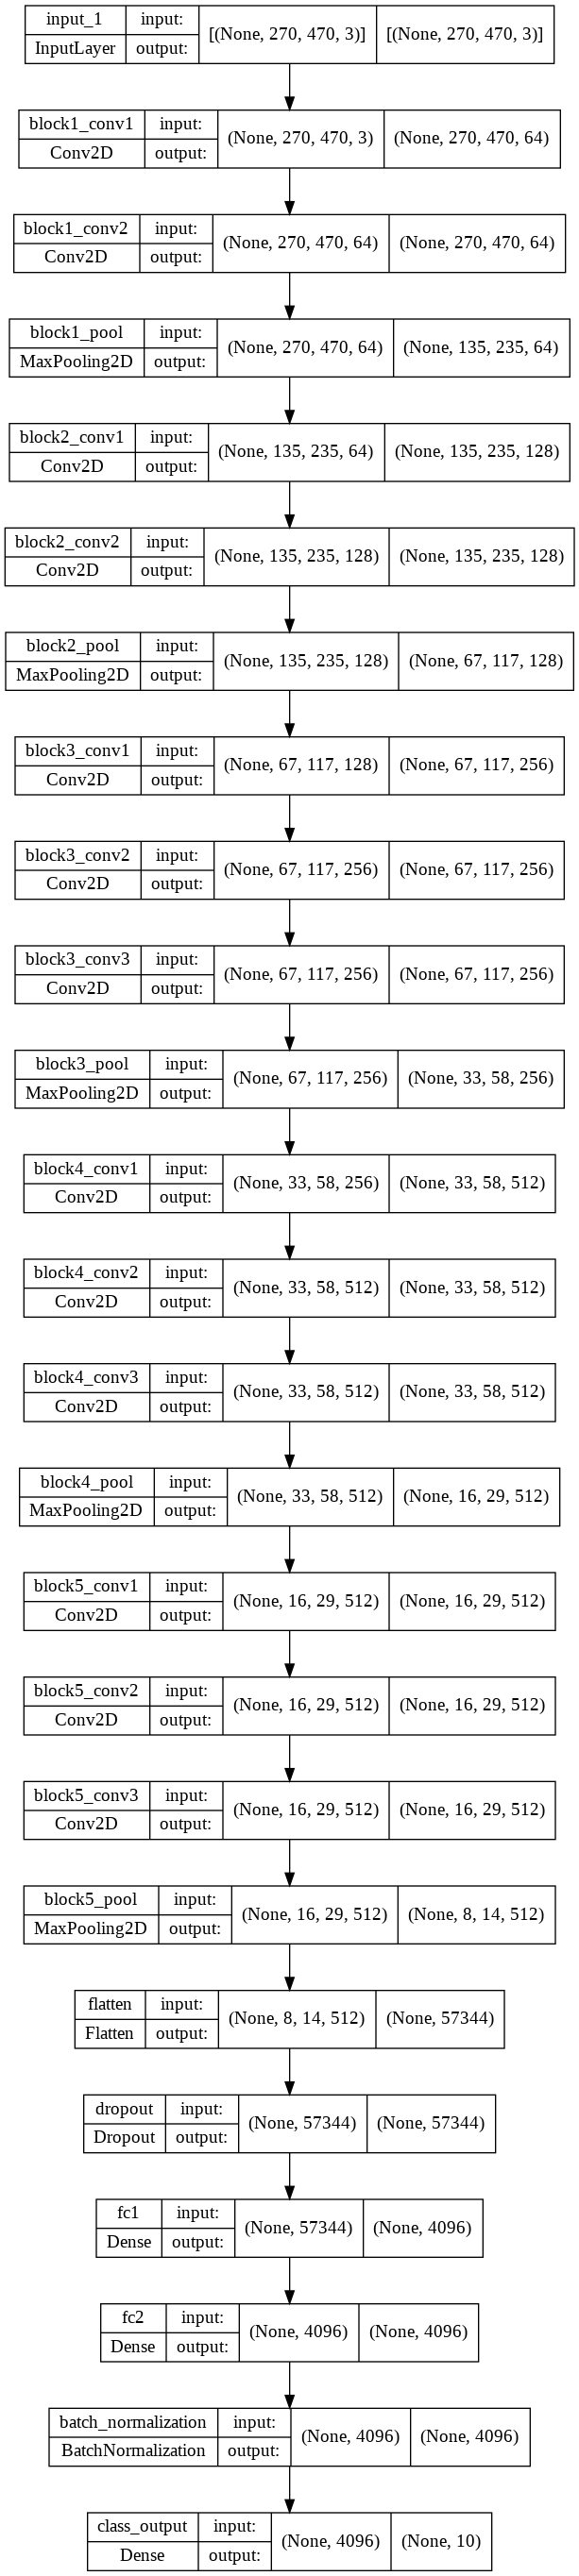

In [ ]:
'''NETWORK'''


model = Sequential()

vgg16_conv = VGG16(include_top=False, weights='imagenet', input_shape=(immg_rows, immg_cols, 3))      #pre allenata con immagini di imagenet, e quindi pesi già esistenti
for layer in vgg16_conv.layers[:-1]:
    layer.trainable = False

##NOTA : in alcune alternative ho visto che applicano il Flatten prima della ramificazione.
x = Flatten(name='flatten')(vgg16_conv.output)
#classifier ramification     
#x = Flatten(name='flatten')(vgg16_conv.output)
x = Dropout(0.5)(x)
x = Dense(4096, activation='relu', name='fc1')(x)
x = Dense(4096, activation='relu', name='fc2')(x)
x = BatchNormalization()(x)
x = Dense(len(classi), activation='softmax', name='class_output')(x)

# stitch together
dot_img_file = '/tmp/model_2.png'

#secondo modello dove faccio la ramificazione
model = keras.Model(vgg16_conv.input, x, name="quality_recognizer")

# inspect
model.summary()

#PLOT DEL MODELLO COMPLETO RAMIFICATO
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

## Metrica Balance Accuracy 

In [ ]:
import keras.backend as K
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
'''
Funzione per Balance Accuracy 
-- Link Utile : https://medium.com/@mostafa.m.ayoub/customize-your-keras-metrics-44ac2e2980bd --
-- https://medium.com/analytics-vidhya/custom-metrics-for-keras-tensorflow-ae7036654e05 --- 
-- https://scikit-learn.org/stable/modules/model_evaluation.html#balanced-accuracy-score --- 
'''

		
'''
Funzione per Balance Accuracy 
'''
def monitor_balance_accuracy ():
	def bal_acc(y_true, y_pred):
		print(y_pred)
		print(len(y_pred))
		print(type(y_pred))
		print(y_true)
		print(len(y_true))
		print(type(y_true))
		#y_true = y_true.numpy().argmax(axis=1) #Returns the indices of the maximum values along an axis.
		#y_pred = y_pred.numpy().argmax(axis=1) #Returns the indices of the maximum values along an axis.
		Balanced_Accuracy = balanced_accuracy_score(y_true, y_pred)
		Balanced_Accuracy = tf.constant(Balanced_Accuracy)
		return K.min(Balanced_Accuracy)
	return bal_acc


#https://medium.com/@mostafa.m.ayoub/customize-your-keras-metrics-44ac2e2980bd
#https://www.statology.org/balanced-accuracy-python-sklearn/
def specificity(y_true, y_pred):
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    return tn / (tn + fp + K.epsilon())

def sensitivity(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def balanced_accuracy_new (y_true, y_pred):
		sensitivity_ = sensitivity(y_true, y_pred)
		specificity_ = specificity(y_true, y_pred)
		BA = (sensitivity_ + specificity_) / 2
		return BA 





## Callbacks 

In [ ]:
'''CALLBACKS'''
from keras.callbacks import ModelCheckpoint, EarlyStopping

#TEST BALANCE ACCURACY 
from sklearn.metrics import balanced_accuracy_score

#NB: create sul drive una cartella weights dove salvare i pesi durante l'allenamento
path_drive = '/content/drive/My Drive/'
path = path_drive+'ProgettoDL/'
model_checkpoint_val_bal_acc = ModelCheckpoint( filepath=os.path.join('/content/drive/My Drive/ProgettoDL/weights/model_{}_{}/best_weights.h5'.format(immgs,cnn)), monitor='val_balanced_accuracy_new', verbose=1, save_best_only=True)
model_checkpoint_val_loss = ModelCheckpoint( filepath=os.path.join('/content/drive/My Drive/ProgettoDL/weights/model_{}_{}/best_weights.h5'.format(immgs,cnn)), monitor='val_loss', verbose=1, save_best_only=True)

### MODIFICATO QUA - Implementazione Early Stopping###
early_stopping_val_bal_acc = tf.keras.callbacks.EarlyStopping(
    monitor='val_balanced_accuracy_new', #Quantity to be monitored 
    min_delta=0, #Minimum change in the monitored quantity to qualify as an improvement
    patience=5, #Number of epochs with no improvement after which training will be stopped
    #verbosity mode, setting verbose 0, 1 or 2 you just say 
    #how do you want to 'see' the training progress for each epoch.
    #verbose=0 will show you nothing (silent)
    #verbose=1 will show you an animated progress bar like this: progres_bar
    verbose=0, 
    #Mode = One of {"auto", "min", "max"}. In min mode, training will stop when the quantity 
    #monitored has stopped decreasing; in "max" mode 
    #it will stop when the quantity monitored has stopped increasing; 
    #in "auto" mode, the direction is automatically inferred from the name of the monitored quantity.
    mode="max",
    #Training will stop if the model doesn't show improvement over the baseline.
    baseline=None,
    #Whether to restore model weights from the epoch with the best value of the monitored quantity
    restore_best_weights=False
)
early_stopping_val_loss = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', #Quantity to be monitored 
    min_delta=0, #Minimum change in the monitored quantity to qualify as an improvement
    patience=5, #Number of epochs with no improvement after which training will be stopped
    #verbosity mode, setting verbose 0, 1 or 2 you just say 
    #how do you want to 'see' the training progress for each epoch.
    #verbose=0 will show you nothing (silent)
    #verbose=1 will show you an animated progress bar like this: progres_bar
    verbose=0, 
    #Mode = One of {"auto", "min", "max"}. In min mode, training will stop when the quantity 
    #monitored has stopped decreasing; in "max" mode 
    #it will stop when the quantity monitored has stopped increasing; 
    #in "auto" mode, the direction is automatically inferred from the name of the monitored quantity.
    mode="auto",
    #Training will stop if the model doesn't show improvement over the baseline.
    baseline=None,
    #Whether to restore model weights from the epoch with the best value of the monitored quantity
    restore_best_weights=False
)
callbacks=[model_checkpoint_val_bal_acc, model_checkpoint_val_loss , early_stopping_val_bal_acc, early_stopping_val_loss ]
#TEST DENIS
#callbacks=[model_checkpoint_val_loss, early_stopping_val_loss ]


## PREPROCESSING & DATA FRAME 

In [ ]:
'''verify that same IDs are in the same sub-sets'''

'''method for univoque sets'''
def check_for_leakage(df1, df2, patient_col):
    """
    Return True if there any patients are in both df1 and df2.

    Args:
        df1 (dataframe): dataframe describing first dataset
        df2 (dataframe): dataframe describing second dataset
        patient_col (str): string name of column with patient IDs
    
    Returns:
        leakage (bool): True if there is leakage, otherwise False
    """
    
    df1_patients_unique = set(df1[patient_col])
    df2_patients_unique = set(df2[patient_col])
    
    patients_in_both_groups = df1_patients_unique.intersection(df2_patients_unique)

    # leakage contains true if there is patient overlap, otherwise false.
    leakage = len(patients_in_both_groups) >= 1 # boolean (true if there is at least 1 patient in both groups)
        
    return leakage

In [ ]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [ ]:
'''PREPROCESSING PHASE OF THE DATAFRAME (CREATIONS OF THE SUBSETS TRAIN/VALIDATION/TEST, CALCULATE WEIGHTS OF ELEMENTS OF THE SUBSETS, VERIFY THAT SAME IDs ARE IN THE SAME SUBSET)'''
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from pandas.compat._optional import import_optional_dependency


os.chdir('/content/drive/MyDrive/ProgettoDL')
path = os.getcwd()


'''reading inforamtions from the CSV'''
col_list_sx = ["ID", "COD_COMPONENTE", "IMG_LATOSX", "CLASSE_CALCIOSX"]
dataframe_sx = pd.read_csv(os.path.join(path + '/20201102_ExportDB.txt'), usecols=col_list_sx, sep=";")


col_list_dx = ["ID", "COD_COMPONENTE", "IMG_LATODX", "CLASSE_CALCIODX"]
dataframe_dx = pd.read_csv(os.path.join(path + '/20201102_ExportDB.txt'), usecols=col_list_dx, sep=";")


'''rename the dataframe columns'''
dataframe_sx.columns = ['ID','series', 'filename', 'class']
dataframe_dx.columns = ['ID','series', 'filename', 'class']

frames = [dataframe_sx, dataframe_dx] 
result = pd.concat(frames) #concatenate the two dataframes

print("------------------------------------------------------------------------------------------------------------------------------------------------------------")
print("DATAFRAME COMPLETO INIZIALE")
print("result")
print(result)


'''mapping the values used for the classification into integer values'''
#version with 10 classes
result["class"] = result["class"].map({'1': int(0), '2-': int(1), '2': int(2), '2+': int(3), '3-': int(4), '3': int(5), '3+': int(6), '4-': int(7), '4': int(8), '4+': int(9)})
result["series"] = result["series"].map({2: int(0), 4: int(1), 8: int(2), 10: int(3), 6: int(4), 9: int(5), 3: int(6), 11: int(7), 12: int(8), 13: int(9), 14: int(10), 15: int(11), 7: int(12)}) 


'''identification of NULL values that would bring the execution on failing and eliminate those values'''
print("------------------------------------------------------------------------------------------------------------------------------------------------------------")
print("Number of Null values in column 'quality_classes' : "+format(result['class'].isnull().sum()))
print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")
#print(result.loc[result['class'] == '0'])
print("mostro quegli elementi che hanno valore nullo")
print(result[result['class'].isnull()])
print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")

'''Remove Null elements to avoid failures during executions (data in not useful!)'''
print("Rimuovo gli elementi nulli e verifico stampando nuovamente i valori nulli:")
result['class'] = pd.to_numeric(result['class'], errors='coerce')
result = result.dropna(subset=['class'])    #rimuovo le righe con elementi nulli

print("elementi nulli rimasti: "+format(result['class'].isnull().sum()))     #stampo per verifica se ci sono elementi nulli


'''verify if images exist in the Google Drive folder, when not present it is eliminated from the dataset aswell'''
print("------------------------------------------------------------------------------------------------------------------------------------------------------------")
print("elimino i file che non sono presenti in Google Drive anche se ci sono nel CSV")
print('CHECK FILE NON PRESENTI NELLA CARTELLA')

#--------TORNA QUI ---------
os.chdir(path_IMAGES)

i = 0; 
for index, row in result.iterrows():
    filename = row['filename']
    if os.path.exists(path_IMAGES+filename) == False:
      
      print('File Non Esiste !!!')
    if(os.path.exists(filename) == False):
      result = result.drop(result[(result['filename'] == filename)].index)
      print('File : {} eliminato'.format(filename))
      i = i + 1             
print('File Eliminati : {} '.format(i))

print('CHECK FILE CON NaN')
print(result[result['class'].isnull()])
print(result[result['series'].isnull()])
print(result[result['filename'].isnull()])
print(result[result['ID'].isnull()])
result = result[result['class'].notna()]
result = result[result['series'].notna()]
result = result[result['filename'].notna()]
result = result[result['ID'].notna()]

'''performing the splitting of the dataframe into sub-sets'''
print("------------------------------------------------------------------------------------------------------------------------------------------------------------")
print("SPLIT DATA")
train_balance_df, test_balance_df, val_balance_df  = split_data(result, 0.2, 0.2, 3)  #CUSTOM SPLIT CON ID IN STESSO SET DI DATI
#train_mask, test_mask, validation_mask  = split_data(result2, 0.2, 0.2, 3)           #split per test con immagini con maschere

print("train_balance_df")
print(train_balance_df)
print("test_balance_df")
print(test_balance_df)
print("val_balance_df")
print(val_balance_df)

'''verify distibution of classes in the sub-sets and calculate weights of the classes in each sub-set'''
print("------------------------------------------------------------------------------------------------------------------------------------------------------------")
vals, counts = np.unique(train_balance_df['class'], return_counts=True)
print("conta del numero di immagini per speicfica classe in set Train")
print(len(train_balance_df))
for i in range(0,len(classi)):
    print('{}:{}'.format(classi[i], counts[i]))

vals2, counts2 = np.unique(val_balance_df['class'], return_counts=True)
print("conta del numero di immagini per speicfica classe in set Validation")
print(len(val_balance_df))
for i in range(0,len(classi)):
    print('{}:{}'.format(classi[i], counts2[i]))

vals3, counts3 = np.unique(test_balance_df['class'], return_counts=True)
print("conta del numero di immagini per speicfica classe in set Test")
print(len(test_balance_df))
for i in range(0,len(classi)):
    print('{}:{}'.format(classi[i], counts3[i]))    


class_weights_train = class_weight.compute_class_weight(class_weight = "balanced",classes = np.unique(train_balance_df['class']),y = train_balance_df['class'])
weight_train = {i : round(class_weights_train[i], 2) for i in range(len(classi))} 
print('Weight train_balance_df')
print(weight_train)

class_weights = class_weight.compute_class_weight(class_weight = "balanced",classes = np.unique(val_balance_df['class']),y = val_balance_df['class'])
weight = {i : round(class_weights[i], 2) for i in range(len(classi))} 
print('Weight val_balance_df')
print(weight)

class_weights = class_weight.compute_class_weight(class_weight = "balanced",classes = np.unique(test_balance_df['class']),y = test_balance_df['class'])
weight = {i : round(class_weights[i], 2) for i in range(len(classi))} 
print('Weight test_balance_df')
print(weight)


'''
print('DENIS Weight train_balance_df')
DENIS_weight_train = weight_train
print(weight_train)
print('------------------')
A = np.fromiter(weight_train.values(), dtype=float)
print('A : {}'.format(A))
print('-------------------')
test_DB_class_weights = np.array(A/np.sum(A))
test_DB_class_weights_new =1/(A/np.min(A))
print(test_DB_class_weights)
print('------------------')
print(test_DB_class_weights_new)
test_DB_class_weights_new = NormalizeData(test_DB_class_weights_new)
print('------------------')
print(test_DB_class_weights_new)
#convert new weight to dictionary
d_weights = dict(enumerate(test_DB_class_weights_new.flatten(), 0))
print(d_weights)
'''

#--------verifico che stessi ID siano in stesso set--------
print("test case 1 - train VS validation")
print(f"Stessi ID in set usati?: {check_for_leakage(train_balance_df, val_balance_df, 'ID')}")
print("-------------------------------------")
print("test case 2 - train VS test")
print(f"Stessi ID in set usati ?: {check_for_leakage(train_balance_df, test_balance_df, 'ID')}")
print("-------------------------------------")
print("test case 3 - validation VS test")
print(f"Stessi ID in set usati?: {check_for_leakage(val_balance_df, test_balance_df, 'ID')}")


------------------------------------------------------------------------------------------------------------------------------------------------------------
DATAFRAME COMPLETO INIZIALE
result
        ID  series            filename class
0        3       2  20201 319 5323.png    3+
1        4       2  20201 3110125 .png    3+
2        5       2  20201 31101327.png    3+
3        6       2  20201 3110161 .png    3+
4        7       2  20201 3110177 .png    3+
...    ...     ...                 ...   ...
1059  2023       7  20201031090549.png    3+
1060  2024       7  20201031090855.png    3+
1061  2025       7  20201031091127.png    3+
1062  2026       7  20201031091720.png    3+
1063  2027       7  20201031091941.png    3+

[2128 rows x 4 columns]
------------------------------------------------------------------------------------------------------------------------------------------------------------
Number of Null values in column 'quality_classes' : 2
- - - - - - - - - - - - - - - - 

In [ ]:
'''Verifica Classi Qualità per ogni Serie'''
print("Verifica Classi Qualità per ogni Serie")
result_x_ = result.groupby(['series','class']).size()
print(result_x_)
result_class = result.groupby(['class']).size()
print(result_class)
result_series = result.groupby(['series']).size()
print(result_series)

print('SOMMA IMG : {}'.format(result_class[0]+result_class[1]+result_class[2]+result_class[3]+result_class[4]+result_class[5]+result_class[6]+result_class[7]+result_class[8]+result_class[9]))
      

Verifica Classi Qualità per ogni Serie
series  class
0       5.0       24
        6.0       85
        7.0        9
        8.0        2
1       1.0       32
        2.0      149
        3.0       26
        4.0       14
        5.0        3
2       0.0        1
        4.0       11
        5.0      176
        6.0       12
3       0.0      151
        1.0       19
        2.0       18
        3.0        4
        4.0        7
        5.0       10
        6.0       13
        7.0        2
        9.0        2
4       5.0        1
        6.0       19
        7.0       99
        8.0      252
        9.0       59
5       2.0        1
        4.0        2
        5.0       33
        6.0       70
        7.0       12
        8.0        2
6       3.0       11
        4.0      141
        5.0       16
7       0.0        3
        1.0       79
        2.0       27
        3.0      105
        4.0        4
8       7.0        8
        8.0        2
        9.0       18
9       0.0       10
  

## D.A. OFFLINE + IMG-AUG


In [ ]:
pip install imgaug -q

In [ ]:
'''IMG-AUG'''
 

import imgaug.augmenters as iaa
import cv2
import glob


# 2. Image Augmentation
augmentation1 = iaa.Sequential([
    # 2. Affine
    #iaa.Affine(scale=(1, 1.5)), #togliere, forse rovina e basta, ma provare
    
    # 3. Linearcontrast
    iaa.LinearContrast((0.8, 1.4))  #cambia solo il colore alzando di tanto il fattore >1
])

augmentation2 = iaa.Sequential([
    # 4. Desaturates some colours
    #iaa.BlendAlphaSomeColors(          #questo non fa col generator
    #iaa.MultiplySaturation(0.5), iaa.MultiplySaturation(1.5)),

    # 5. Brightness change
    #iaa.WithBrightnessChannels(iaa.Add((-10,0))),
    iaa.Multiply((0.8, 1.2))  #alternativa brightness/darkness
])

augmentation3 = iaa.Sequential([

    # 1. Flip
    iaa.Fliplr(0.5)
])

augmentation4 = iaa.Sequential([
    iaa.Flipud(0.5)
])

    # 6. Histogram equalization
    #iaa.AllChannelsHistogramEqualization(),  #cambia troppo 

    # 7. Sharpen
    #iaa.Sharpen(alpha=(0.6, 1)), #non aiuta

    # 8. Distortion
    #iaa.PiecewiseAffine(scale=(0.01, 0.1)), #disturba, cambia troppo geometria, se usare max deve essere 0.03

    # 9. Random 4 points transformations
    #iaa.PerspectiveTransform(scale=(0.01, 0.15))


# 1. Load Dataset


images = []
NUOVO_PATH_TEST = path_IMAGES+'*.png'
print(NUOVO_PATH_TEST)
i = 0
images_path = glob.glob(NUOVO_PATH_TEST)
for img_path in images_path:
    img = cv2.imread(img_path)
    #print(img.dtype)
    images.append(img)
    i = i + 1 
    if i > 5:
      break



from google.colab.patches import cv2_imshow
# 3. Show Images

augmented_images = augmentation1(images=images)
for img in augmented_images:
    cv2_imshow(img)
    #print(img.dtype)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from tensorflow.keras.utils import save_img
from skimage import io, exposure

print(train_balance_df)
train_balance_df_copy = train_balance_df
n_img_for_class = np.zeros(10)
for i in range(10):
  n_img_for_class[i] = len(train_balance_df[train_balance_df['class']==i])
print(f'n° immagini per ciascuna classe ', n_img_for_class) #-- il n° di img per ciascuna classe 

classe_maggioritaria = np.max(n_img_for_class)
classe_minoritaria = np.min(n_img_for_class)
print(f'La classe maggioritaria contiene n: ',classe_maggioritaria,'immagini')
print(f'La classe minoritaria contiene n: ',classe_minoritaria,'immagini')
index_min = np.argmin(n_img_for_class)
index_max = np.argmax(n_img_for_class)
print(f'classe minima : ',index_min)
print(f'classe massima : ',index_max)


# calcolo n° immagini da creare per ciascuna classe di qualità - non lo usiamo direttamente
n_img_for_class_to_create = n_img_for_class
print(f'n° immagini da creare per ciascuna classe ', n_img_for_class_to_create) #-- il n° di img per ciascuna classe 


#Data Augmentation Offline - Parto dalla prima classe di qualità e genero immagini volta per volta fino ad arrivare al numero della maggioritaria
k=0
j=0
i=0
for k in range(10): 
  #print(k)
  actual_df = train_balance_df[train_balance_df['class']==k]
  #print(actual_df)
  if n_img_for_class_to_create[k] > 0:
    print(f'devo creare immagini della classe : ',k)
    n_img_in_actual_df = len(actual_df)
    print(f'len actual df', n_img_in_actual_df)
    count = n_img_in_actual_df
    #for row in range(int(n_img_in_actual_df)):
    for i in range(4):  #sono 4 trasformazioni da fare (in modo indipendente)
      print(i)
      for j in range(count):
        row_selected = actual_df.iloc[j]
        filename = row_selected['filename']
        img_path = os.path.join(path_IMAGES+filename) 
          
        if i==0: 
          if os.path.exists(path_IMAGES+'DA-offline/T1_'+filename) == False:
            image = io.imread(img_path)

            
            #image_bright = exposure.adjust_gamma(image, gamma=0.5, gain=1)
            augmented_image = augmentation1(images=image)

            '''
            imagee = cv2.imread(img_path)
            augmented_images = augmentation1(images=imagee)
            '''


            io.imsave(path_IMAGES+'DA-offline/T1_'+filename,image)
          row_selected['filename'] = 'DA-offline/T1_'+filename
          train_balance_df_copy = train_balance_df_copy.append(row_selected, ignore_index = True)   
        
        if i==1: 
          if os.path.exists(path_IMAGES+'DA-offline/T2_'+filename) == False:
            image = io.imread(img_path)
            
            
            #horizontal flip
            #image = image[:, ::-1]
            augmented_image = augmentation2(images=image)

            '''
            imagee = cv2.imread(img_path)
            augmented_images = augmentation2(images=imagee)
            '''
            
            
            io.imsave(path_IMAGES+'DA-offline/T2_'+filename, image)
          row_selected['filename'] = 'DA-offline/T2_'+filename
          train_balance_df_copy = train_balance_df_copy.append(row_selected, ignore_index = True)  
          
        if i==2: 
          if os.path.exists(path_IMAGES+'DA-offline/T3_'+filename) == False:
            image = io.imread(img_path)
            
            
            #vertical flip
            #image = image[::-1, :]
            augmented_image = augmentation3(images=image)

            '''
            imagee = cv2.imread(img_path)
            augmented_images = augmentation3(images=imagee)
            '''
            
            
            io.imsave(path_IMAGES+'DA-offline/T3_'+filename, image)
          row_selected['filename'] = 'DA-offline/T3_'+filename
          train_balance_df_copy = train_balance_df_copy.append(row_selected, ignore_index = True) 

        if i==3: 
          if os.path.exists(path_IMAGES+'DA-offline/T4_'+filename) == False:
            image = io.imread(img_path)
            
            
            #vertical flip
            #image = image[::-1, :]
            augmented_image = augmentation4(images=image)

            '''
            imagee = cv2.imread(img_path)
            augmented_images = augmentation4(images=imagee)
            '''
            
            
            io.imsave(path_IMAGES+'DA-offline/T4_'+filename, image)
          row_selected['filename'] = 'DA-offline/T4_'+filename
          train_balance_df_copy = train_balance_df_copy.append(row_selected, ignore_index = True)          

  else:
    print(f'non devo creare immagini della classe : ',k)
# check di verifica 
#print(f'class_weight train_balance_df',compute_sample_weight(class_weight='balanced', y=train_balance_df['class']))
print(f'class_weight train_balance_df_copy',compute_sample_weight(class_weight='balanced', y=train_balance_df_copy['class']))       #questo print NON torna il rapporto in OUTPUT, ma il numero di immagini è corretto (prossimo print)!
n_img_for_class_after = np.zeros(10)
for i in range(10):
  n_img_for_class_after[i] = len(train_balance_df_copy[train_balance_df_copy['class']==i])
print(f'n° immagini per ciascuna classe ', n_img_for_class_after) #-- il n° di img per ciascuna classe 




        ID series            filename  class
0      398      4  20203 3 7 0 38.png    7.0
1      398      4  20203 3 7 0 19.png    8.0
2     1944     12  20201010071452.png    6.0
3     1944     12  20201010071339.png    6.0
4      463      4  20203 108 147 .png    8.0
...    ...    ...                 ...    ...
1269   521      4  20203 10110 49.png    7.0
1270   265      2  20202 14123442.png    5.0
1271   265      2  20202 14123432.png    5.0
1272  1942     12  20201010070727.png    5.0
1273  1942     12  20201010070550.png    5.0

[1274 rows x 4 columns]
n° immagini per ciascuna classe  [ 95.  83. 132. 110. 111. 179. 206. 125. 171.  62.]
La classe maggioritaria contiene n:  206.0 immagini
La classe minoritaria contiene n:  62.0 immagini
classe minima :  9
classe massima :  6
n° immagini da creare per ciascuna classe  [ 95.  83. 132. 110. 111. 179. 206. 125. 171.  62.]
devo creare immagini della classe :  0
len actual df 95
0


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()


1
2
3


/usr/local/lib/python3.7/dist-packages/imgaug/augmenters/base.py:38: SuspiciousMultiImageShapeWarning: You provided a numpy array of shape (495, 1050, 3) as a multi-image augmentation input, which was interpreted as (N, H, W). The last dimension however has value 1 or 3, which indicates that you provided a single image with shape (H, W, C) instead. If that is the case, you should use e.g. augmenter(image=<your input>) or augment_image(<your input>) -- note the singular 'image' instead of 'imageS'. Otherwise your single input image will be interpreted as multiple images of shape (H, W) during augmentation.
  category=SuspiciousMultiImageShapeWarning)


devo creare immagini della classe :  1
len actual df 83
0
1
2
3
devo creare immagini della classe :  2
len actual df 132
0
1
2
3
devo creare immagini della classe :  3
len actual df 110
0
1
2
3
devo creare immagini della classe :  4
len actual df 111
0
1
2
3
devo creare immagini della classe :  5
len actual df 179
0
1
2
3
devo creare immagini della classe :  6
len actual df 206
0
1
2
3
devo creare immagini della classe :  7
len actual df 125
0
1
2
3
devo creare immagini della classe :  8
len actual df 171
0
1
2
3
devo creare immagini della classe :  9
len actual df 62
0
1
2
3
class_weight train_balance_df_copy [1.0192     0.74502924 0.6184466  ... 2.05483871 2.05483871 2.05483871]
n° immagini per ciascuna classe  [ 475.  415.  660.  550.  555.  895. 1030.  625.  855.  310.]


In [ ]:
print(train_balance_df_copy[train_balance_df_copy['class']==1])

        ID series                          filename  class
11    1648      7                20200519080822.png    1.0
27     366      3                20203 2 9 3932.png    1.0
56    1752      7                20200526194818.png    1.0
57    1752      7                20200526194809.png    1.0
61    1748      7                20200526193405.png    1.0
...    ...    ...                               ...    ...
1803  1610      1  DA-offline/T3_20200515193828.png    1.0
1804  1742      7  DA-offline/T3_20200526192944.png    1.0
1805  1742      7  DA-offline/T3_20200526192932.png    1.0
1806  1613      1  DA-offline/T3_20200515194253.png    1.0
1807  1766      9  DA-offline/T3_20200528174300.png    1.0

[332 rows x 4 columns]


In [ ]:
'''
#VERSIONE VECCHIA CON D.A. BILANCIATO PER NUMERO IMMAGINI IN CIASCUNA CLASSE
from tensorflow.keras.utils import save_img
from skimage import io, exposure

print(train_balance_df)
train_balance_df_copy = train_balance_df
n_img_for_class = np.zeros(10)
for i in range(10):
  n_img_for_class[i] = len(train_balance_df[train_balance_df['class']==i])
print(f'n° immagini per ciascuna classe ', n_img_for_class) #-- il n° di img per ciascuna classe 

classe_maggioritaria = np.max(n_img_for_class)
classe_minoritaria = np.min(n_img_for_class)
print(f'La classe maggioritaria contiene n: ',classe_maggioritaria,'immagini')
print(f'La classe minoritaria contiene n: ',classe_minoritaria,'immagini')
index_min = np.argmin(n_img_for_class)
index_max = np.argmax(n_img_for_class)
print(f'classe minima : ',index_min)
print(f'classe massima : ',index_max)


# calcolo n° immagini da creare per ciascuna classe di qualità - non lo usiamo direttamente
n_img_for_class_to_create = np.zeros(10)
for i in range(10):
  n_img_for_class_to_create[i] = classe_maggioritaria - n_img_for_class[i] 
print(f'n° immagini da creare per ciascuna classe ', n_img_for_class_to_create) #-- il n° di img per ciascuna classe 


#Data Augmentation Offline - Parto dalla prima classe di qualità e genero immagini volta per volta fino ad arrivare al numero della maggioritaria
for k in range(10): 
  #print(k)
  actual_df = train_balance_df[train_balance_df['class']==k]
  #print(actual_df)
  if n_img_for_class_to_create[k] > 0:
    print(f'devo creare immagini della classe : ',k)
    n_img_in_actual_df = len(actual_df)
    print(f'len actual df', n_img_in_actual_df)
    count = n_img_in_actual_df
    #for row in range(int(n_img_in_actual_df)):
    for i in range(int(abs(classe_maggioritaria/classe_minoritaria))): 
      for row in range(int(n_img_in_actual_df)):
        if (count < classe_maggioritaria):
          count = count + 1
          row_selected = actual_df.iloc[row]

          filename = row_selected['filename']
          
          img_path = os.path.join(path_IMAGES+filename)
          
          if i==0: 
            if os.path.exists(path_IMAGES+'T1_'+filename) == False:
              image = io.imread(img_path)
              image_bright = exposure.adjust_gamma(image, gamma=0.5, gain=1)
              io.imsave(path_IMAGES+'T1_'+filename,image)
            row_selected['filename'] = 'T1_'+filename
            train_balance_df_copy = train_balance_df_copy.append(row_selected, ignore_index = True)   
          
          if i==1: 
            if os.path.exists(path_IMAGES+'T2_'+filename) == False:
              image = io.imread(img_path)
              #horizontal flip
              image = image[:, ::-1]
              io.imsave(path_IMAGES+'T2_'+filename, image)
            row_selected['filename'] = 'T2_'+filename
            train_balance_df_copy = train_balance_df_copy.append(row_selected, ignore_index = True)  
           
          if i==2: 
            if os.path.exists(path_IMAGES+'T3_'+filename) == False:
              image = io.imread(img_path)
              #vertical flip
              image = image[::-1, :]
              io.imsave(path_IMAGES+'T3_'+filename, image)
            row_selected['filename'] = 'T3_'+filename
            train_balance_df_copy = train_balance_df_copy.append(row_selected, ignore_index = True)           

        else: 
          break
  else:
    print(f'non devo creare immagini della classe : ',k)
# check di verifica 
#print(f'class_weight train_balance_df',compute_sample_weight(class_weight='balanced', y=train_balance_df['class']))
print(f'class_weight train_balance_df_copy',compute_sample_weight(class_weight='balanced', y=train_balance_df_copy['class']))
n_img_for_class_after = np.zeros(10)
for i in range(10):
  n_img_for_class_after[i] = len(train_balance_df_copy[train_balance_df_copy['class']==i])
print(f'n° immagini per ciascuna classe ', n_img_for_class_after) #-- il n° di img per ciascuna classe 

'''


"\n#VERSIONE VECCHIA CON D.A. BILANCIATO PER NUMERO IMMAGINI IN CIASCUNA CLASSE\nfrom tensorflow.keras.utils import save_img\nfrom skimage import io, exposure\n\nprint(train_balance_df)\ntrain_balance_df_copy = train_balance_df\nn_img_for_class = np.zeros(10)\nfor i in range(10):\n  n_img_for_class[i] = len(train_balance_df[train_balance_df['class']==i])\nprint(f'n° immagini per ciascuna classe ', n_img_for_class) #-- il n° di img per ciascuna classe \n\nclasse_maggioritaria = np.max(n_img_for_class)\nclasse_minoritaria = np.min(n_img_for_class)\nprint(f'La classe maggioritaria contiene n: ',classe_maggioritaria,'immagini')\nprint(f'La classe minoritaria contiene n: ',classe_minoritaria,'immagini')\nindex_min = np.argmin(n_img_for_class)\nindex_max = np.argmax(n_img_for_class)\nprint(f'classe minima : ',index_min)\nprint(f'classe massima : ',index_max)\n\n\n# calcolo n° immagini da creare per ciascuna classe di qualità - non lo usiamo direttamente\nn_img_for_class_to_create = np.zeros(

In [ ]:
#train_balance_df_copy

## Weighted Categorical Crossentropy Loss 

In [ ]:
from keras import backend as K
class weighted_categorical_crossentropy(object):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        loss = weighted_categorical_crossentropy(weights).loss
        model.compile(loss=loss,optimizer='adam')
    """
    
    def __init__(self,weights):
        self.weights = K.variable(weights)
        
    def loss(self,y_true, y_pred): 
        # scale preds so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred)
        # clip
        y_pred = K.clip(y_pred, K.epsilon(), 1)
        # calc
        
        loss = y_true*K.log(y_pred)*self.weights
        loss =-K.sum(loss,-1)
        return loss

## HYPERPARAMETERS

In [ ]:
#Definizione hyperparameters                                                                                                                         #prova SGD

#opt = Adam(learning_rate=	0.01)
opt = SGD(learning_rate = 0.001, decay = 1e-4, momentum= 0.7)

num_epochs = 100 
bs = 128

model.compile(optimizer=opt, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=["accuracy",balanced_accuracy_new])  

## Creazione TrainGen, ValGen, TestGen 

In [ ]:
#traingen = CustomDataGen(train_balance_df, X_col={'PATH_IMG':'filename'}, y_col={'CLASSE': 'class'}, batch_size=bs, input_size=(270,470))
traingen = CustomDataGen(train_balance_df_copy, X_col={'PATH_IMG':'filename'}, y_col={'CLASSE': 'class'}, batch_size=bs, input_size=(270,470))
testgen = CustomDataGen(test_balance_df, X_col={'PATH_IMG':'filename'}, y_col={'CLASSE': 'class'}, batch_size=bs, input_size=(270,470))   
valgen = CustomDataGen(val_balance_df, X_col={'PATH_IMG':'filename'}, y_col={'CLASSE': 'class'}, batch_size=bs, input_size=(270,470))

## Testing Model 

In [ ]:
from sklearn.preprocessing import LabelBinarizer

history = model.fit(x=traingen,validation_data=valgen, epochs=num_epochs, callbacks = [callbacks] , verbose=1)
print(history.history.keys()) #---serve per stampare le metriche che ho nel modello 


Epoch 1/100
39/39 [==============================] - ETA: 0s - loss: 2.7974 - accuracy: 0.1965 - balanced_accuracy_new: 0.5280 
Epoch 1: val_balanced_accuracy_new improved from -inf to 0.73799, saving model to /content/drive/My Drive/ProgettoDL/weights/model_CALCIO_CROP_vgg16/best_weights.h5

Epoch 1: val_loss improved from inf to 1.37504, saving model to /content/drive/My Drive/ProgettoDL/weights/model_CALCIO_CROP_vgg16/best_weights.h5
39/39 [==============================] - 1417s 36s/step - loss: 2.7974 - accuracy: 0.1965 - balanced_accuracy_new: 0.5280 - val_loss: 1.3750 - val_accuracy: 0.5677 - val_balanced_accuracy_new: 0.7380
Epoch 2/100
39/39 [==============================] - ETA: 0s - loss: 2.4527 - accuracy: 0.2784 - balanced_accuracy_new: 0.5566
Epoch 2: val_balanced_accuracy_new improved from 0.73799 to 0.74537, saving model to /content/drive/My Drive/ProgettoDL/weights/model_CALCIO_CROP_vgg16/best_weights.h5

Epoch 2: val_loss improved from 1.37504 to 1.21836, saving mode

## PLOT 

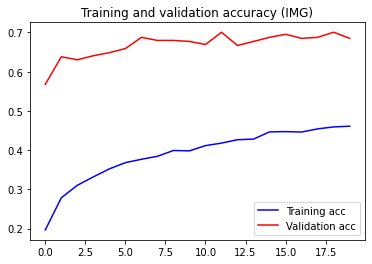

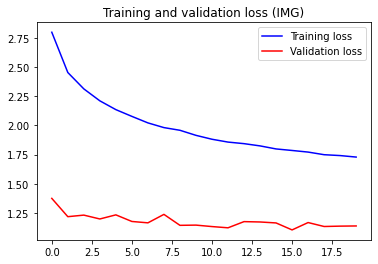

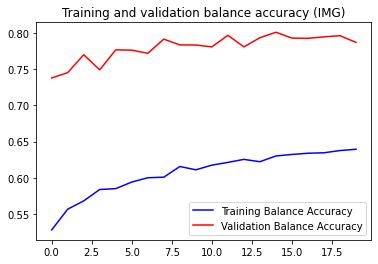

In [ ]:
'''PLOT CURVES'''

path = path_drive+'ProgettoDL/'

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
bal_acc = history.history['balanced_accuracy_new']
val_bal_acc = history.history['val_balanced_accuracy_new']
lista = [acc,val_acc,loss,val_loss,bal_acc, val_bal_acc]


#print(corr(history.history['accuracy'], history_mask.history_mask['accuracy']))

import csv

with open("VGG16.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(lista)
     
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy (IMG)')
plt.legend()
plt.savefig(os.path.join(path+'weights/PlotAcc_{}_{}.pdf'.format(immgs,cnn))) 

plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss (IMG)')
plt.legend()
plt.savefig(os.path.join(path+'weights/PlotLoss_{}_{}.pdf'.format(immgs,cnn)))

plt.figure()

plt.plot(epochs, bal_acc, 'b', label='Training Balance Accuracy')
plt.plot(epochs, val_bal_acc, 'r', label='Validation Balance Accuracy')
plt.title('Training and validation balance accuracy (IMG)')
plt.legend()
plt.savefig(os.path.join(path+'weights/PlotBalAcc_{}_{}.pdf'.format(immgs,cnn)))

## SAVE MODEL 

In [ ]:
#salvataggio modello pesi finali
from tensorflow.keras.models import Sequential, save_model, load_model
path = path_drive+'ProgettoDL/'
model.save(os.path.join(path+'weights/model_{}_{}/Final'.format(immgs,cnn)))
print("Saved model to disk")

Saved model to disk


## LOAD MODEL 

In [ ]:
'''TEST'''
import os
from tensorflow.keras.models import Sequential, save_model, load_model
path_drive = '/content/drive/My Drive/'
path = path_drive+'ProgettoDL/'

path_model = os.path.join(path+'weights/model_{}_{}/Final'.format(immgs,cnn))


'''
Per evitare di fare compile=False, forse sarebbe da aggiungere metric bal_acc nel nostro caso --- da fare comunque perché non è corretto così 
model = load_model(model_path, custom_objects={'conditional_average_metric': conditional_average_metric, 'specificity': specificity, 'sensitivity': sensitivity})
'''
#model = load_model(path_model, compile=False)
model = load_model(path_model, custom_objects={'balanced_accuracy_new':balanced_accuracy_new})

print('Model IMG Loaded')


Model IMG Loaded


## PREDICTION 

In [ ]:
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras import Model
from keras.applications.vgg16 import preprocess_input

test_array = []
test_array_series = []

for index, row in test_balance_df.iterrows():
    class_ = int(row['class'])
    series_ = int(row['series'])          #---da qui e nei prossimi, calcolo la ground thruth del shotgun series, ovvero i semplici COD_COMPONENTE (serie) che appartengono al sub-set di test
    test_array.append(class_)
    test_array_series.append(series_)     #---

test_array = np.array(test_array)
test_array_series = np.array(test_array_series)   #---

y_test = to_categorical(np.unique(test_array, return_inverse=True)[1])
y_test_series = to_categorical(np.unique(test_array_series, return_inverse=True)[1])      #---

imgs_array = [] 


for index, row in testgen.df.iterrows():
    filename = row['filename'] 
    image = load_img(os.path.join(path_IMAGES,filename), target_size = (immg_rows, immg_cols))
    x = img_to_array(image)
    x = preprocess_input(x, data_format="channels_first")  #non dovrebbe servire
    imgs_array.append(x)
    X_test = np.asarray(imgs_array)


In [ ]:
y_test_no_argmax = y_test
y_test = y_test.argmax(axis=1)

y_test_series = y_test_series.argmax(axis=1)      #---
y_pred = model.predict(X_test)
#---------------
#metriche nuove senza usare argmax.
#---------------
y_pred_no_argmax = y_pred
y_pred = np.argmax(y_pred,axis=1)

print(y_pred.shape)
print(y_test.shape)

print(y_pred_no_argmax.shape)
print(y_test_no_argmax)
print(y_test_no_argmax.shape)

#y_pred_conf = model.predict(X_test)
#index = np.where(np.equal(y_pred, y_test) == False)[0]
#print(np.around(y_pred_conf[index], decimals = 2))

(424,)
(424,)
(424, 10)
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(424, 10)


In [ ]:
print(y_test)
print(y_test.shape)
print(y_test_series)
print(y_test_series.shape)
print(y_pred)
print(y_pred.shape)

[0 0 0 4 0 0 0 0 0 0 0 1 7 7 0 0 5 5 1 3 5 5 8 8 6 6 3 4 6 6 0 0 7 8 7 6 4
 4 8 8 5 6 4 5 4 4 1 1 0 2 5 5 4 4 1 1 0 0 8 7 0 0 7 8 7 7 1 3 7 7 6 7 4 4
 3 3 6 6 7 8 2 1 1 2 5 5 7 8 7 8 7 8 3 3 6 6 6 5 0 0 5 5 6 6 9 9 5 5 6 6 5
 6 5 6 9 9 8 8 9 9 6 6 5 5 2 2 2 2 0 1 6 6 2 2 1 1 8 8 6 6 3 3 1 1 1 1 9 9
 7 7 1 1 1 1 4 4 2 2 4 4 5 5 5 5 8 8 8 8 3 3 8 8 5 6 2 2 2 2 8 8 9 9 5 5 1
 1 5 5 6 6 5 5 5 5 6 6 5 5 3 3 5 5 1 1 6 6 0 0 6 6 0 2 4 4 2 2 4 4 8 8 0 2
 5 5 0 0 0 0 9 9 8 8 7 7 7 8 6 6 5 5 1 1 2 2 0 0 1 1 9 9 1 1 9 9 4 0 6 6 4
 4 8 8 6 8 5 5 6 6 1 2 5 6 3 3 3 3 6 6 6 6 1 2 6 5 4 4 7 7 6 7 1 1 0 0 4 5
 6 6 8 8 8 8 2 2 6 5 7 7 5 5 4 4 6 6 5 6 2 1 4 4 8 7 2 2 7 7 4 4 6 6 8 8 3
 3 6 6 7 7 2 2 9 8 6 6 2 1 7 8 2 3 3 3 5 5 6 6 0 0 5 6 7 7 5 6 7 8 2 5 8 9
 5 4 7 8 6 6 8 8 2 2 7 7 7 8 9 9 9 9 9 7 3 3 5 5 5 4 1 3 2 3 8 8 4 4 7 7 3
 3 5 5 7 7 2 2 6 6 1 1 5 5 6 6 5 5]
(424,)
[ 3  3  3  3  3  3  3  3  3  3  7  7 11 11  3  3  2  2  7  7  2  2  4  4
  3  3  6  6 12 12  3  3  8  8  0  0  6  6  4  4  0  0  6  

##SEARCH UNIVOQUE SERIES TO BALANCE SETS

In [ ]:
#SEARCHING UNIVOQUE SERIES
test_array_s0, test_array_s1, test_array_s2, test_array_s3, test_array_s4, test_array_s5, test_array_s6, test_array_s7, test_array_s8, test_array_s9, test_array_s10, test_array_s11, test_array_s12 = [], [], [], [], [], [], [], [], [], [], [], [], []
pred_array_s0, pred_array_s1, pred_array_s2, pred_array_s3, pred_array_s4, pred_array_s5, pred_array_s6, pred_array_s7, pred_array_s8, pred_array_s9, pred_array_s10, pred_array_s11, pred_array_s12 = [], [], [], [], [], [], [], [], [], [], [], [], []
i=0
for index, row in test_balance_df.iterrows():
    
    series_ = int(row['series'])
    if series_ == 0:
      test_array_s0.append(y_test[i])
      pred_array_s0.append(y_pred[i])
    if series_ == 1:
      test_array_s1.append(y_test[i])
      pred_array_s1.append(y_pred[i])
    if series_ == 2:
      test_array_s2.append(y_test[i])
      pred_array_s2.append(y_pred[i])
    if series_ == 3:
      test_array_s3.append(y_test[i])
      pred_array_s3.append(y_pred[i])
    if series_ == 4:
      test_array_s4.append(y_test[i])
      pred_array_s4.append(y_pred[i])
    if series_ == 5:
      test_array_s5.append(y_test[i])
      pred_array_s5.append(y_pred[i])
    if series_ == 6:
      test_array_s6.append(y_test[i])
      pred_array_s6.append(y_pred[i])
    if series_ == 7:
      test_array_s7.append(y_test[i])
      pred_array_s7.append(y_pred[i])
    if series_ == 8:
      test_array_s8.append(y_test[i])
      pred_array_s8.append(y_pred[i])
    if series_ == 9:
      test_array_s9.append(y_test[i])
      pred_array_s9.append(y_pred[i])
    if series_ == 10:
      test_array_s10.append(y_test[i])
      pred_array_s10.append(y_pred[i])
    if series_ == 11:
      test_array_s11.append(y_test[i])
      pred_array_s11.append(y_pred[i])
    if series_ == 12:
      test_array_s12.append(y_test[i])
      pred_array_s12.append(y_pred[i])

    i=i+1

print(test_array_s0)
print(pred_array_s0)

from functools import reduce
reduced = reduce(np.union1d, (pred_array_s0, test_array_s0))
print(reduced)

[7, 6, 5, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 6, 6, 6, 5, 6, 6]
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
[5 6 7]


## METRICHE MASK & IMG 

In [ ]:
'''METRICHE'''
print('--------------Metrice IMG----------------')

a = accuracy_score(y_test, y_pred)                                              # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
print("test accuracy: {0:0.4f}".format(a))
print("precision: {0:0.4f}".format(precision_score(y_test, y_pred , average="macro")))         # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html?highlight=precision_score#sklearn.metrics.precision_score
print("recall: {0:0.4f}".format(recall_score(y_test, y_pred , average="macro")))                # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html?highlight=recall_score#sklearn.metrics.recall_score
print("f1_score: {0:0.4f}".format(f1_score(y_test, y_pred , average="macro")))                # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html?highlight=f1_score#sklearn.metrics.f1_score

print('classification report:')
print(classification_report(y_test, y_pred))  



--------------Metrice IMG----------------
test accuracy: 0.6321
precision: 0.6081
recall: 0.6044
f1_score: 0.5902
classification report:
              precision    recall  f1-score   support

           0       0.69      0.95      0.80        37
           1       0.64      0.36      0.46        39
           2       0.63      0.45      0.52        38
           3       0.39      0.54      0.45        28
           4       0.68      0.86      0.76        35
           5       0.76      0.61      0.68        64
           6       0.71      0.80      0.75        69
           7       0.53      0.42      0.47        43
           8       0.58      0.81      0.68        48
           9       0.46      0.26      0.33        23

    accuracy                           0.63       424
   macro avg       0.61      0.60      0.59       424
weighted avg       0.63      0.63      0.62       424



Per quanto riguarda la funzione np_quadratic_weighted_kappa abbiamo avuto alcune difficoltà implementative e quindi abbiamo cercato un codice online che ci calcolasse la stessa metrica 

[Link Utilizzato](https://www.kaggle.com/aroraaman/quadratic-kappa-metric-explained-in-5-simple-steps)

In [ ]:

# The following 3 functions have been taken from Ben Hamner's github repository
# https://github.com/benhamner/Metrics
def Cmatrix(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Returns the confusion matrix between rater's ratings
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat


def histogram(ratings, min_rating=None, max_rating=None):
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings

def quadratic_weighted_kappa(y, y_pred):
    """
    Calculates the quadratic weighted kappa
    axquadratic_weighted_kappa calculates the quadratic weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    quadratic_weighted_kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
    quadratic_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    rater_a = y
    rater_b = y_pred
    min_rating=1 # era None abbiamo messo 0
    max_rating=9 # era None abbiamo messo 9
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = Cmatrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return (1.0 - numerator / denominator)

In [ ]:
path_drive = '/content/drive/My Drive/'
path = path_drive+'ProgettoDL/'

os.chdir(path)

from metrics import np_quadratic_weighted_kappa, minimum_sensitivity
from sklearn.metrics import mean_absolute_error

#errore no graph before run 
tf.compat.v1.disable_eager_execution()



def compute_metrics(y_true, y_pred, num_classes):

  #run function minimum_sensitivity


  # Calculate metric
  sess = keras.backend.get_session()

  #qwk = np_quadratic_weighted_kappa(np.argmax(y_true, axis=0), np.argmax(y_pred, axis=0), 0,
	#									num_classes - 1)
  
  qwk = quadratic_weighted_kappa(y_true, y_pred)
  ms = minimum_sensitivity(y_test_no_argmax, y_pred_no_argmax)
  mae = sess.run(K.mean(keras.losses.mean_absolute_error(y_test_no_argmax, y_pred_no_argmax)))
  
  metrics = {
		'QWK': qwk,
		'MS': ms,
		'MAE': mae}
  
  return metrics

def print_metrics(metrics):
	print('QWK: {:.4f}'.format(metrics['QWK']))
	print('MS: {:.4f}'.format(metrics['MS']))
	print('MAE: {:.4f}'.format(metrics['MAE']))    


#-----codice------

num_classi = 10
metrics = compute_metrics(y_test, y_pred,num_classi)
print_metrics(metrics)

with open("metrics.txt", "w") as text_file:
    print(print_metrics, file=text_file)





QWK: 0.7601
MS: 0.2609
MAE: 0.0965


***Metrice Ottenute***

**K Cohen**   https://it.vvikipedla.com/wiki/Cohen%27s_kappa
Il Kappa di Cohen è un coefficiente statistico che rappresenta il grado di accuratezza e affidabilità in una classificazione statistica; è un indice di concordanza che tiene conto della probabilità di concordanza casuale; l'indice calcolato in base al rapporto tra l'accordo in eccesso rispetto alla probabilità di concordanza casuale e l'eccesso massimo ottenibile. Attraverso la matrice di confusione è possibile valutare questo parametro. In particolare ... Esistono diversi "gradi di concordanza", in base ai quali possiamo definire se Kappa di Cohen è scarso o ottimo:

- se k assume valori inferiori a 0, allora non c'è concordanza;
- se k assume valori compresi tra 0-0,4, allora la concordanza è scarsa;
- se k assume valori compresi tra 0,4-0,6, allora la concordanza è discreta;
- se k assume valori compresi tra 0,6-0,8, la concordanza è buona;
- se k assume valori compresi tra 0,8-1, la concordanza è ottima.

**QWK**: 0.7849

BLA BLA BLA 

**MS**: 1.0000


In statistics, **mean absolute error (MAE)** is a measure of errors between paired observations expressing the same phenomenon. Examples of Y versus X include comparisons of predicted versus observed, subsequent time versus initial time, and one technique of measurement versus an alternative technique of measurement. 

**MAE**: 0.0000

## PLOT CONFUSION MATRIX FUNCTION 

In [ ]:
#Confusion Matrix - CROP
import sklearn.metrics as metrics

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    fig = plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i in range (cm.shape[0]):
      for j in range (cm.shape[1]):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    axes = plt.gca()
    bottom, top = axes.get_ylim()
    axes.set_ylim(bottom + 0.5, top - 0.5)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
    return fig




## PLOT CONFUSION MATRIX 

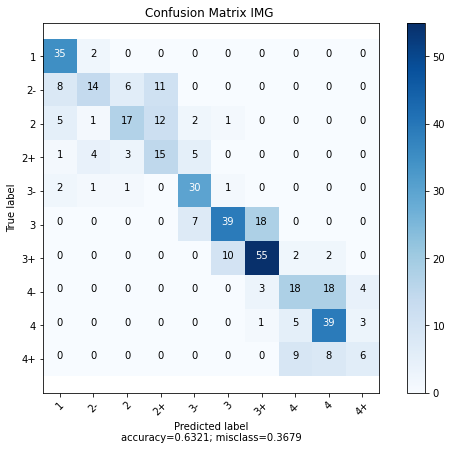

In [ ]:
import sklearn.metrics as metrics
cm = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred)
fig = plot_confusion_matrix(cm,
                      target_names = classi,
                      normalize    = False,
                      title        = "Confusion Matrix IMG ")
fig.savefig(os.path.join(path+'weights/CM_{}_{}.pdf'.format(immgs,cnn))) 

##PLOT CONFUSION MATRIX PER CIASCUNA SERIE DEL CALCIO 

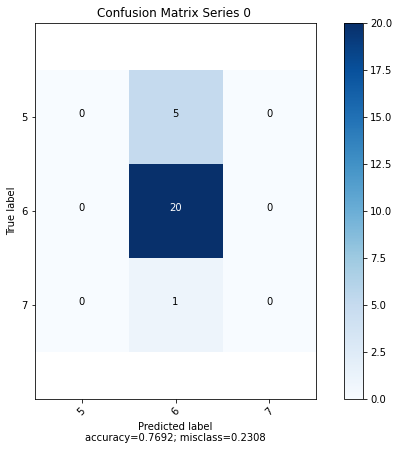

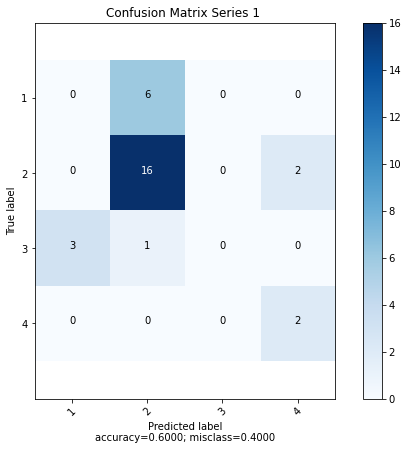

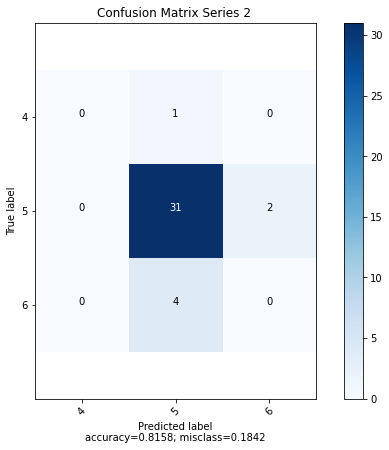

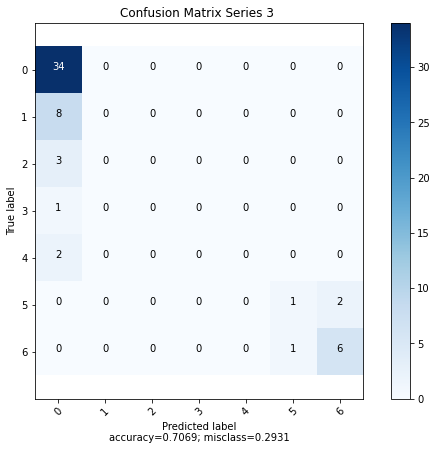

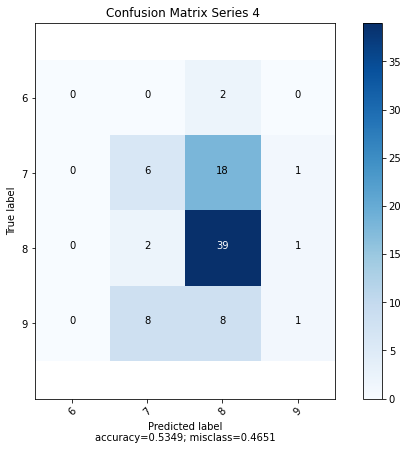

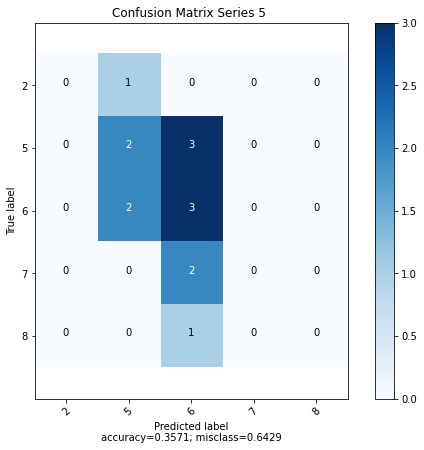

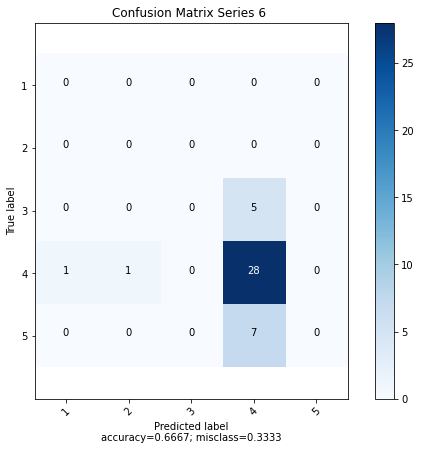

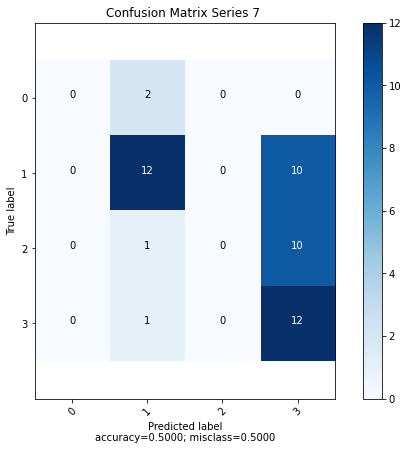

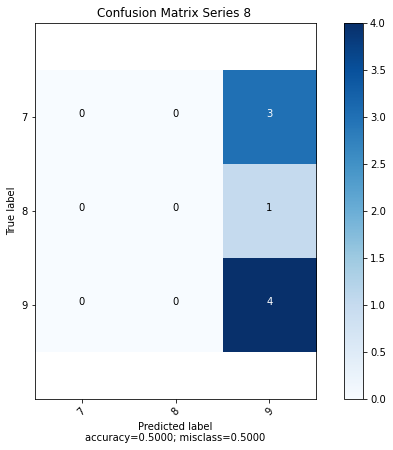

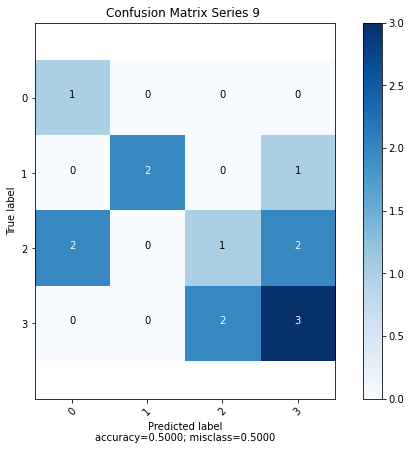

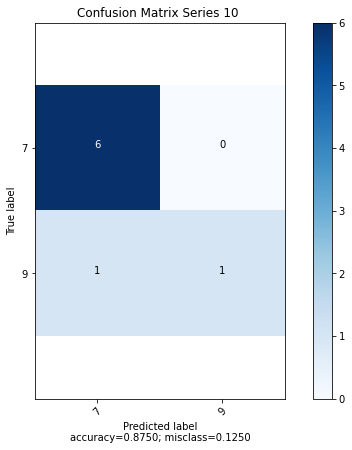

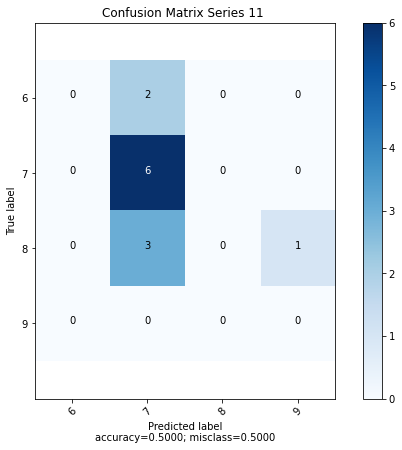

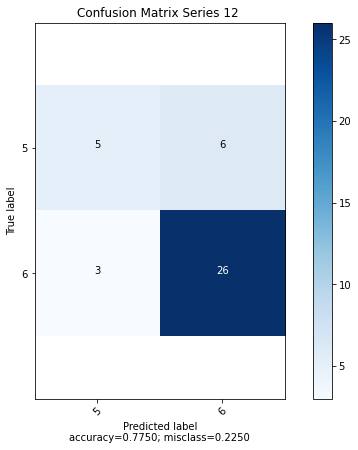

In [ ]:
import sklearn.metrics as metrics
from functools import reduce
#serie 0
cm0 = metrics.confusion_matrix(y_true=test_array_s0, y_pred=pred_array_s0)
fig = plot_confusion_matrix(cm0,
                      target_names = reduce(np.union1d, (pred_array_s0, test_array_s0)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 0 ")
fig.savefig(os.path.join(path+'weights/CM_serie0_{}_{}.pdf'.format(immgs,cnn))) 

#serie 1
cm1 = metrics.confusion_matrix(y_true=test_array_s1, y_pred=pred_array_s1)
fig = plot_confusion_matrix(cm1,
                      target_names = reduce(np.union1d, (pred_array_s1, test_array_s1)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 1 ")
fig.savefig(os.path.join(path+'weights/CM_serie1_{}_{}.pdf'.format(immgs,cnn))) 

#serie 2
cm2 = metrics.confusion_matrix(y_true=test_array_s2, y_pred=pred_array_s2)
fig = plot_confusion_matrix(cm2,
                      target_names = reduce(np.union1d, (pred_array_s2, test_array_s2)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 2 ")
fig.savefig(os.path.join(path+'weights/CM_serie2_{}_{}.pdf'.format(immgs,cnn))) 

#serie 3
cm3 = metrics.confusion_matrix(y_true=test_array_s3, y_pred=pred_array_s3)
fig = plot_confusion_matrix(cm3,
                      target_names = reduce(np.union1d, (pred_array_s3, test_array_s3)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 3 ")
fig.savefig(os.path.join(path+'weights/CM_serie3_{}_{}.pdf'.format(immgs,cnn))) 

#serie 4
cm4 = metrics.confusion_matrix(y_true=test_array_s4, y_pred=pred_array_s4)
fig = plot_confusion_matrix(cm4,
                      target_names = reduce(np.union1d, (pred_array_s4, test_array_s4)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 4 ")
fig.savefig(os.path.join(path+'weights/CM_serie4_{}_{}.pdf'.format(immgs,cnn))) 

#serie 5
cm5 = metrics.confusion_matrix(y_true=test_array_s5, y_pred=pred_array_s5)
fig = plot_confusion_matrix(cm5,
                      target_names = reduce(np.union1d, (pred_array_s5, test_array_s5)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 5 ")
fig.savefig(os.path.join(path+'weights/CM_serie5_{}_{}.pdf'.format(immgs,cnn))) 

#serie 6
cm6 = metrics.confusion_matrix(y_true=test_array_s6, y_pred=pred_array_s6)
fig = plot_confusion_matrix(cm6,
                      target_names = reduce(np.union1d, (pred_array_s6, test_array_s6)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 6 ")
fig.savefig(os.path.join(path+'weights/CM_serie6_{}_{}.pdf'.format(immgs,cnn))) 

#serie 7
cm7 = metrics.confusion_matrix(y_true=test_array_s7, y_pred=pred_array_s7)
fig = plot_confusion_matrix(cm7,
                      target_names = reduce(np.union1d, (pred_array_s7, test_array_s7)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 7 ")
fig.savefig(os.path.join(path+'weights/CM_serie7_{}_{}.pdf'.format(immgs,cnn))) 

#serie 8
cm8 = metrics.confusion_matrix(y_true=test_array_s8, y_pred=pred_array_s8)
fig = plot_confusion_matrix(cm8,
                      target_names = reduce(np.union1d, (pred_array_s8, test_array_s8)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 8 ")
fig.savefig(os.path.join(path+'weights/CM_serie8_{}_{}.pdf'.format(immgs,cnn))) 

#serie 9 
cm9 = metrics.confusion_matrix(y_true=test_array_s9, y_pred=pred_array_s9)
fig = plot_confusion_matrix(cm9,
                      target_names = reduce(np.union1d, (pred_array_s9, test_array_s9)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 9 ")
fig.savefig(os.path.join(path+'weights/CM_serie9_{}_{}.pdf'.format(immgs,cnn))) 

#serie 10
cm10 = metrics.confusion_matrix(y_true=test_array_s10, y_pred=pred_array_s10)
fig = plot_confusion_matrix(cm10,
                      target_names = reduce(np.union1d, (pred_array_s10, test_array_s10)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 10 ")
fig.savefig(os.path.join(path+'weights/CM_serie10_{}_{}.pdf'.format(immgs,cnn))) 

#serie 11
cm11 = metrics.confusion_matrix(y_true=test_array_s11, y_pred=pred_array_s11)
fig = plot_confusion_matrix(cm11,
                      target_names = reduce(np.union1d, (pred_array_s11, test_array_s11)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 11 ")
fig.savefig(os.path.join(path+'weights/CM_serie11_{}_{}.pdf'.format(immgs,cnn))) 


cm12 = metrics.confusion_matrix(y_true=test_array_s12, y_pred=pred_array_s12)
fig = plot_confusion_matrix(cm12,
                      target_names = reduce(np.union1d, (pred_array_s12, test_array_s12)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 12 ")
fig.savefig(os.path.join(path+'weights/CM_serie12_{}_{}.pdf'.format(immgs,cnn))) 

## CRAMER V CORRELATION

In [ ]:
#PRIMA VERSIONE
import pandas as pd
import numpy as np
import scipy.stats as ss
import seaborn as sns

def cramers_v(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

confusion_matrix = pd.crosstab(y_test, y_pred)
print("cramer correlation tra predizioni delle classi, e le classi effettive")
cramer1 = cramers_v(confusion_matrix.values)
print(cramer1)

confusion_matrix2 = pd.crosstab(y_test_series, y_pred)
print("cramer correlation tra predizioni delle classi e le ground thruth di shotgun series")
cramer2 = cramers_v(confusion_matrix2.values)
print(cramer2)

cramer correlation tra predizioni delle classi, e le classi effettive
0.6195192646583161
cramer correlation tra predizioni delle classi e le ground thruth di shotgun series
0.7881249177985247


In [ ]:
#SECONDA VERSIONE.        https://www.youtube.com/watch?v=eTnLTJer_Oo
contTable = pd.crosstab(y_test_series, y_pred)
print(contTable)

!pip install researchpy

import researchpy

crosstab, res = researchpy.crosstab(pd.Series(y_test_series), pd.Series(y_pred), test='chi-square')
print("\n{}".format(res))

df = min(contTable.shape[0], contTable.shape[1]) - 1
print("\ndf = {}".format(df))

V = res.iloc[2,1]
print("V = {}".format(V))

if df == 1:
    if V < 0.10:
        qual = 'negligible'
    elif V < 0.30:
        qual = 'small'
    elif V < 0.50:
        qual = 'medium'
    else:
        qual = 'large'
elif df == 2:
    if V < 0.07:
        qual = 'negligible'
    elif V < 0.21:
        qual = 'small'
    elif V < 0.35:
        qual = 'medium'
    else:
        qual = 'large'
elif df == 3:
    if V < 0.06:
        qual = 'negligible'
    elif V < 0.17:
        qual = 'small'
    elif V < 0.29:
        qual = 'medium'
    else:
        qual = 'large'
elif df == 4:
    if V < 0.05:
        qual = 'negligible'
    elif V < 0.15:
        qual = 'small'
    elif V < 0.25:
        qual = 'medium'
    else:
        qual = 'large'
else:
    if V < 0.05:
        qual = 'negligible'
    elif V < 0.13:
        qual = 'small'
    elif V < 0.22:
        qual = 'medium'
    else:
        qual = 'large'

print("\nquality classification of the correlation is:   {}".format(qual))


col_0   0   1   2   3   4   5   6   7   8  9
row_0                                       
0       0   0   0   0   0   0  26   0   0  0
1       0   3  23   0   4   0   0   0   0  0
2       0   0   0   0   0  36   2   0   0  0
3      48   0   0   0   0   2   8   0   0  0
4       0   0   0   0   0   0   0  16  67  3
5       0   0   0   0   0   5   9   0   0  0
6       0   1   1   0  40   0   0   0   0  0
7       0  16   0  32   0   0   0   0   0  0
8       0   0   0   0   0   0   0   0   0  8
9       3   2   3   6   0   0   0   0   0  0
10      0   0   0   0   0   0   0   7   0  1
11      0   0   0   0   0   0   0  11   0  1
12      0   0   0   0   0   8  32   0   0  0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

                  Chi-square test    results
0  Pearson Chi-square ( 108.0) =   2428.0976
1                      p-value =      0.0000
2                   Cramer's V =      0.7977

df = 9
V = 0.7977

quality classification of

To indicate the strength of the association between two nominal variables, Cramér's V (Cramér, 1946) is often used.

As for the interpretation for Cramér's V various rules of thumb exist but one of them is from Cohen (1988, pp. 222, 224, 225) who let's the interpretation depend on the degrees of freedom, shown in the table below.

|df*|negligible|small|medium|large|
|-------|---|---|---|---|
|1|0 < .10|.10 < .30|.30 < .50|.50 or more|
|2|0 < .07|.07 < .21|.21 < .35|.35 or more|
|3|0 < .06|.06 < .17|.17 < .29|.29 or more|
|4|0 < .05|.05 < .15|.15 < .25|.25 or more|
|5|0 < .05|.05 < .13|.13 < .22|.22 or more|

The degrees of freedom (df*) is for Cramér's V the minimum of the number of rows, or number of columns, then minus one.

Lets see how to obtain Cramér's V with Python, using an example.




**A SECONDA DEI RISULTATI E CONFRONTANDOLI CON LA TABELLA RIUSCIAMO A CAPIRE L'INTENSITA' DEL BIAS TRA DIVERSE VARIABILI**

## **T-SNE  & PCA**


### Spiegazioni, Link Utili e Implementazione 

***(t-SNE)*** t-Distributed Stochastic Neighbor Embedding is a non-linear dimensionality reduction algorithm used for exploring high-dimensional data. It maps multi-dimensional data to two or more dimensions suitable for human observation. With help of the t-SNE algorithms, you may have to plot fewer exploratory data analysis plots next time you work with high dimensional data.

[Link utile ](https://www.analyticsvidhya.com/blog/2017/01/t-sne-implementation-r-python/)

***(PCA) Principal Component Analysis***
Lʹanalisi delle componenti principali (detta pure PCA oppure CPA) è una tecnica utilizzata nell’ambito della statistica multivariata per la semplificazione dei dati d’origine.
Lo scopo primario di questa tecnica è la riduzione di un numero più o meno elevato di variabili (rappresentanti altrettante caratteristiche del fenomeno analizzato) in alcune variabili latenti. Ciò avviene tramite una trasformazione lineare delle variabili che proietta quelle originarie in un nuovo sistema cartesiano nel quale le variabili vengono ordinate in ordine decrescente di varianza: pertanto, la variabile con maggiore varianza viene proiettata sul primo asse, la seconda sul secondo asse e così via. La riduzione della complessità avviene limitandosi ad analizzare le principali (per varianza) tra le nuove variabili.
Diversamente da altre trasformazioni (lineari) di variabili praticate nellʹambito della statistica, in questa tecnica sono gli stessi dati che determinano i vettori di trasformazione.
[Step By Step](https://www.youtube.com/watch?v=FgakZw6K1QQ)

[Link Utile](https://www.analyticsvidhya.com/blog/2020/12/an-end-to-end-comprehensive-guide-for-pca/) 

***Parametri del TSNE***
1. **n_components** int, default=2 - Dimension of the embedded space.

2. **perplexityfloat, default=30.0** - The perplexity is related to the number of nearest neighbors that is used in other manifold learning algorithms. Larger datasets usually require a larger perplexity. Consider selecting a value between 5 and 50. Different values can result in significantly different results.

3. **early_exaggeration float, default=12.0**
Controls how tight natural clusters in the original space are in the embedded space and how much space will be between them. For larger values, the space between natural clusters will be larger in the embedded space. Again, the choice of this parameter is not very critical. If the cost function increases during initial optimization, the early exaggeration factor or the learning rate might be too high.

4. **learning_ratefloat, default=200.0** The learning rate for t-SNE is usually in the range [10.0, 1000.0]. If the learning rate is too high, the data may look like a ‘ball’ with any point approximately equidistant from its nearest neighbours. If the learning rate is too low, most points may look compressed in a dense cloud with few outliers. If the cost function gets stuck in a bad local minimum increasing the learning rate may help.

5. **n_iterint, default=1000**
Maximum number of iterations for the optimization. Should be at least 250.

6. **n_iter_without_progressint, default=300**
Maximum number of iterations without progress before we abort the optimization, used after 250 initial iterations with early exaggeration. Note that progress is only checked every 50 iterations so this value is rounded to the next multiple of 50.

7. **metricstr or callable, default=’euclidean’**
The metric to use when calculating distance between instances in a feature array. If metric is a string, it must be one of the options allowed by scipy.spatial.distance.pdist for its metric parameter, or a metric listed in pairwise.PAIRWISE_DISTANCE_FUNCTIONS. If metric is “precomputed”, X is assumed to be a distance matrix. Alternatively, if metric is a callable function, it is called on each pair of instances (rows) and the resulting value recorded. The callable should take two arrays from X as input and return a value indicating the distance between them. The default is “euclidean” which is interpreted as squared euclidean distance.

8. **init{‘random’, ‘pca’} or ndarray of shape(n_samples, n_components), default=’random’**
Initialization of embedding. Possible options are ‘random’, ‘pca’, and a numpy array of shape (n_samples, n_components). PCA initialization cannot be used with precomputed distances and is usually more globally stable than random initialization.

9. **verboseint, default=0** Verbosity level.

10. **random_stateint, RandomState instance or None, default=None** Determines the random number generator. Pass an int for reproducible results across multiple function calls. Note that different initializations might result in different local minima of the cost function. See :term: Glossary <random_state>.

11. **methodstr, default=’barnes_hut’**
By default the gradient calculation algorithm uses Barnes-Hut approximation running in O(NlogN) time. method=’exact’ will run on the slower, but exact, algorithm in O(N^2) time. The exact algorithm should be used when nearest-neighbor errors need to be better than 3%. However, the exact method cannot scale to millions of examples.

12. **n_jobsint, default=None**
The number of parallel jobs to run for neighbors search. This parameter has no impact when metric="precomputed" or (metric="euclidean" and method="exact"). None means 1 unless in a joblib.parallel_backend context. -1 means using all processors. See Glossary for more details.


[scikit-learn.org](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

[misread-tsne](https://distill.pub/2016/misread-tsne/)

[altro modo spiegato anche meglio](https://www.analyticsvidhya.com/blog/2017/01/t-sne-implementation-r-python/)


#### Dataset 

In [ ]:
'''
import numpy as np
from keras.models import Sequential
import numpy as np
from sklearn.model_selection import train_test_split
import os
import pandas as pd

os.chdir('/content/drive/MyDrive/ProgettoDL')
path = os.getcwd()

col_list_sx = ["ID", "COD_COMPONENTE", "IMG_LATOSX", "CLASSE_CALCIOSX"]
dataframe_sx_complessivo = pd.read_csv(os.path.join(path + '/20201102_ExportDB.txt'), usecols=col_list_sx, sep=";")


col_list_dx = ["ID", "COD_COMPONENTE", "IMG_LATODX", "CLASSE_CALCIODX"]
dataframe_dx_complessivo = pd.read_csv(os.path.join(path + '/20201102_ExportDB.txt'), usecols=col_list_dx, sep=";")


dataframe_sx_complessivo.columns = ['ID','series', 'filename', 'class']
dataframe_dx_complessivo.columns = ['ID','series', 'filename', 'class']

#print(dataframe_sx.columns)                 #stampo i due elementi con stesso ID (lato dx e sx di stesso CALCIO)
frames = [dataframe_sx_complessivo, dataframe_dx_complessivo]
result_complessivo = pd.concat(frames)
#print(result_complessivo)
#print(result_complessivo.loc[[1]])
#print(type(result_complessivo.loc[[1]]))

result_complessivo["class"] = result_complessivo["class"].map({'1': int(0), '2-': int(1), '2': int(2), '2+': int(3), '3-': int(4), '3': int(5), '3+': int(6), '4-': int(7), '4': int(8), '4+': int(9)})
result_complessivo["series"] = result_complessivo["series"].map({2: int(0), 4: int(1), 8: int(2), 10: int(3), 6: int(4), 9: int(5), 3: int(6), 11: int(7), 12: int(8), 13: int(9), 14: int(10), 15: int(11), 7: int(12)})

#IDENTIFICAZIONE VALORI NULL 
print("Null VALUE di class : "+format(result_complessivo['class'].isnull().sum()))
print(result_complessivo.loc[result_complessivo['class'] == '0'])
print(result_complessivo[result_complessivo['class'].isnull()])
result_complessivo['class'] = pd.to_numeric(result_complessivo['class'], errors='coerce')
print(result_complessivo[result_complessivo['class'].isnull()])
result_complessivo = result_complessivo.dropna(subset=['class'])    #rimuovo le righe con elementi nulli
print(result_complessivo[result_complessivo['class'].isnull()])

print("Null VALUE di class : "+format(result_complessivo['class'].isnull().sum()))

#IMMG EXIST ?  (cerco se qualche path non esiste e lo elimino dal dataframe) e se esiste ne faccio la MASCHERA
import os.path
from os import path
os.chdir('/content/drive/MyDrive/CALCIO_NOPRE')
for index, row in result_complessivo.iterrows():
    filename = row['filename']
    if(os.path.exists(filename) == False):
      result_complessivo = result_complessivo.drop(result_complessivo[(result_complessivo['filename'] == filename)].index)
      print('File : {} eliminato'.format(filename))

print('------------------- DATASET BASE ---------------')
print(type(result_complessivo))  
print(len(result_complessivo))
print(result_complessivo)

result_complessivo_totale = pd.DataFrame()

for index, row in result_complessivo.iterrows():
  #filename_mask = 'mask_{}'.format(row['filename'])
  filename = '{}'.format(row['filename'])
  #filename_gray = 'gray_{}'.format(row['filename'])
  class_ = row['class']
  series_ = row['series']
  #print('{}_{}_{}_{}'.format(filename_gray,filename_mask, class_, series_)) "ID": row['ID']
  row_df_1 = pd.DataFrame({"ID": row['ID'], "series" : series_, "filename" : filename, "class" : class_},index=[0])
  #row_df_2 = pd.DataFrame({"ID": row['ID'], "series" : series_, "filename" : filename_gray, "class" : class_},index=[0])
  #row_df_3 = pd.DataFrame({"ID": row['ID'], "series" : series_, "filename" : filename, "class" : class_},index=[0])
  #print(row_df_1)
  #print(row_df_2)
  result_complessivo_totale = result_complessivo_totale.append(row_df_1)
  #result_complessivo_totale = result_complessivo_totale.append(row_df_2)
  #result_complessivo_totale = result_complessivo_totale.append(row_df_3)


print('------------------- DATASET COMPLESSIVO ---------------') 
print(type(result_complessivo_totale))  
print(len(result_complessivo_totale))
#print(result_complessivo_totale)

from sklearn.utils import shuffle
result_complessivo_totale = shuffle(result_complessivo_totale)
print(type(result_complessivo_totale))  
print(len(result_complessivo_totale))
print(result_complessivo_totale)
'''

'\nimport numpy as np\nfrom keras.models import Sequential\nimport numpy as np\nfrom sklearn.model_selection import train_test_split\nimport os\nimport pandas as pd\n\nos.chdir(\'/content/drive/MyDrive/ProgettoDL\')\npath = os.getcwd()\n\ncol_list_sx = ["ID", "COD_COMPONENTE", "IMG_LATOSX", "CLASSE_CALCIOSX"]\ndataframe_sx_complessivo = pd.read_csv(os.path.join(path + \'/20201102_ExportDB.txt\'), usecols=col_list_sx, sep=";")\n\n\ncol_list_dx = ["ID", "COD_COMPONENTE", "IMG_LATODX", "CLASSE_CALCIODX"]\ndataframe_dx_complessivo = pd.read_csv(os.path.join(path + \'/20201102_ExportDB.txt\'), usecols=col_list_dx, sep=";")\n\n\ndataframe_sx_complessivo.columns = [\'ID\',\'series\', \'filename\', \'class\']\ndataframe_dx_complessivo.columns = [\'ID\',\'series\', \'filename\', \'class\']\n\n#print(dataframe_sx.columns)                 #stampo i due elementi con stesso ID (lato dx e sx di stesso CALCIO)\nframes = [dataframe_sx_complessivo, dataframe_dx_complessivo]\nresult_complessivo = pd.con

#### import utili per il TSNE e PCA

In [ ]:
'''
%matplotlib inline
from __future__ import print_function
import time
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import datasets
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.manifold import TSNE
import pandas as pd    
from sklearn.preprocessing import StandardScaler
'''

'\n%matplotlib inline\nfrom __future__ import print_function\nimport time\nimport numpy as np\nimport pandas as pd\nfrom sklearn.decomposition import PCA\nfrom sklearn.manifold import TSNE\nfrom sklearn import datasets\nimport matplotlib.pyplot as plt\nimport matplotlib.pyplot as plt\nfrom mpl_toolkits.mplot3d import Axes3D\nimport seaborn as sns\nfrom sklearn.manifold import TSNE\nimport pandas as pd    \nfrom sklearn.preprocessing import StandardScaler\n'

#### IMG to ARRAY per il calcolo del PCA e TSNE & Reduction delle immagini

##### IMG to ARRAY per il calcolo del PCA e TSNE & Reduction delle immagini - QUALITY CLASS

In [ ]:
'''
# https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b
from tqdm import tqdm
immg_rows = 270 
immg_cols = 470
X = [] 
imgs_array_tot = []

data_X = result_complessivo_totale['filename'][:1000] #---versione originale 
result_complessivo_totale_min = result_complessivo_totale[:1000] #--deve essere uguale a y_dim ---versione originale 
y = result_complessivo_totale['class'][:1000] #--- deve essere uguale ... ---versione originale 

for index, row in tqdm(result_complessivo_totale_min.iterrows()):
    filename = row['filename']
    image = load_img('/content/drive/My Drive/CALCIO_CROP_BASE/{}'.format(filename), target_size = (immg_rows, immg_cols, 1), color_mode="grayscale")
    
    #print('Originale : {} x {} x {}'.format(image.size[0], image.size[1], len(image.size)-1))
    #plt.imshow(image)
    scale_percent = 90 # percent of original size
    width, height = image.size
    #print('channel : {}'.format(len(image.size)))
    width = int(width * scale_percent / 100)
    height = int(height * scale_percent / 100)
    dim = (width, height)
    # resize image
    x = img_to_array(image)
    resized = cv2.resize(x, dim, interpolation = cv2.INTER_AREA)
    #print('Ridimensionata : {}'.format((resized.shape)))
    #print('Resized Dimensions : ',resized.shape)
    imgs_array_tot.append(resized)
    X = np.asarray(imgs_array_tot)
print(X.shape)
'''

'\n# https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b\nfrom tqdm import tqdm\nimmg_rows = 270 \nimmg_cols = 470\nX = [] \nimgs_array_tot = []\n\ndata_X = result_complessivo_totale[\'filename\'][:1000] #---versione originale \nresult_complessivo_totale_min = result_complessivo_totale[:1000] #--deve essere uguale a y_dim ---versione originale \ny = result_complessivo_totale[\'class\'][:1000] #--- deve essere uguale ... ---versione originale \n\nfor index, row in tqdm(result_complessivo_totale_min.iterrows()):\n    filename = row[\'filename\']\n    image = load_img(\'/content/drive/My Drive/CALCIO_CROP_BASE/{}\'.format(filename), target_size = (immg_rows, immg_cols, 1), color_mode="grayscale")\n    \n    #print(\'Originale : {} x {} x {}\'.format(image.size[0], image.size[1], len(image.size)-1))\n    #plt.imshow(image)\n    scale_percent = 90 # percent of original size\n    width, height = image.size\n    #print(\'channel : {}\

##### IMG to ARRAY per il calcolo del PCA e TSNE & Reduction delle immagini - SHOTGUN SERIES

In [ ]:
'''
# https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b
from tqdm import tqdm

immg_rows = 270 
immg_cols = 470
X = [] 
imgs_array_tot = []
data_X = result_complessivo_totale['filename'][:1000]

result_complessivo_totale_min = result_complessivo_totale[:1000] #--deve essere uguale a y_dim

y = result_complessivo_totale['class'][:1000] #--- deve essere uguale ... 

y_series = result_complessivo_totale['series'][:1000] #--- deve essere uguale ...

for index, row in tqdm(result_complessivo_totale_min.iterrows()):
    filename = row['filename']
    if(filename[0] == 'm'):
      image = load_img('/content/drive/My Drive/MASK_CALCIO_CROP/{}'.format(filename), target_size = (immg_rows, immg_cols, 1), color_mode="grayscale")
    elif(filename[0] == 'g'): 
      image = load_img('/content/drive/My Drive/GRAY_CALCIO_CROP/{}'.format(filename), target_size = (immg_rows, immg_cols, 1), color_mode="grayscale")
    else:
      image = load_img('/content/drive/My Drive/CALCIO_CROP/{}'.format(filename), target_size = (immg_rows, immg_cols, 1), color_mode="grayscale")

    scale_percent = 90 # percent of original size
    width, height = image.size
    width = int(width * scale_percent / 100)
    height = int(height * scale_percent / 100)
    dim = (width, height)
    # resize image
    x = img_to_array(image)
    resized = cv2.resize(x, dim, interpolation = cv2.INTER_AREA)
    #print('Ridimensionata : {}'.format((resized.shape)))
    #print('Resized Dimensions : ',resized.shape)
    imgs_array_tot.append(resized)
    X2 = np.asarray(imgs_array_tot)
print(X2.shape) 
'''

'\n# https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b\nfrom tqdm import tqdm\n\nimmg_rows = 270 \nimmg_cols = 470\nX = [] \nimgs_array_tot = []\ndata_X = result_complessivo_totale[\'filename\'][:1000]\n\nresult_complessivo_totale_min = result_complessivo_totale[:1000] #--deve essere uguale a y_dim\n\ny = result_complessivo_totale[\'class\'][:1000] #--- deve essere uguale ... \n\ny_series = result_complessivo_totale[\'series\'][:1000] #--- deve essere uguale ...\n\nfor index, row in tqdm(result_complessivo_totale_min.iterrows()):\n    filename = row[\'filename\']\n    if(filename[0] == \'m\'):\n      image = load_img(\'/content/drive/My Drive/MASK_CALCIO_CROP/{}\'.format(filename), target_size = (immg_rows, immg_cols, 1), color_mode="grayscale")\n    elif(filename[0] == \'g\'): \n      image = load_img(\'/content/drive/My Drive/GRAY_CALCIO_CROP/{}\'.format(filename), target_size = (immg_rows, immg_cols, 1), color_mode="graysc

#### Check & Create Dataframe for PCA (Principal Analysis Component) & T-SNE (t-distributed stochastic neighbor embedding)

##### classi di qualità 

In [ ]:
'''
print('X SHAPE : {}'.format(X.shape))

nsamples = X.shape[0]
rows = X.shape[1]
cols = X.shape[2]
channel = 1

print('n_samples : {} , rows : {} , cols : {} , channel : {} '.format(nsamples, rows, cols, channel))
print(type(X))
X_1 = np.reshape(X, (X.shape[0],rows*cols*channel)) #-- serve per modificare la dimensione, per il fit_transform          FORSE QUI BISOGNA SOLO USARE I PRIMI 2 VALORI E IL 3 DEI CANALI NO!

print('X MODIFICATO : {}'.format(X_1.shape)) #--- controllo se ho fatto tutto correttamente 

feat_cols = [ 'pixel'+str(i) for i in range(X_1.shape[1]) ]
print('Feat Cols : {} '.format(len(feat_cols)))
#print(feat_cols)
df = pd.DataFrame(X_1,columns=feat_cols)
#df = pd.DataFrame(X_1)
df['y'] = pd.DataFrame({ 'y': np.array(y) })
df['label'] = df['y'].apply(lambda i: str(i))
#X, y = None, None
print('Size of the dataframe: {}'.format(df.shape))

# For reproducability of the results
np.random.seed(42)
rndperm = np.random.permutation(df.shape[0])
'''

"\nprint('X SHAPE : {}'.format(X.shape))\n\nnsamples = X.shape[0]\nrows = X.shape[1]\ncols = X.shape[2]\nchannel = 1\n\nprint('n_samples : {} , rows : {} , cols : {} , channel : {} '.format(nsamples, rows, cols, channel))\nprint(type(X))\nX_1 = np.reshape(X, (X.shape[0],rows*cols*channel)) #-- serve per modificare la dimensione, per il fit_transform          FORSE QUI BISOGNA SOLO USARE I PRIMI 2 VALORI E IL 3 DEI CANALI NO!\n\nprint('X MODIFICATO : {}'.format(X_1.shape)) #--- controllo se ho fatto tutto correttamente \n\nfeat_cols = [ 'pixel'+str(i) for i in range(X_1.shape[1]) ]\nprint('Feat Cols : {} '.format(len(feat_cols)))\n#print(feat_cols)\ndf = pd.DataFrame(X_1,columns=feat_cols)\n#df = pd.DataFrame(X_1)\ndf['y'] = pd.DataFrame({ 'y': np.array(y) })\ndf['label'] = df['y'].apply(lambda i: str(i))\n#X, y = None, None\nprint('Size of the dataframe: {}'.format(df.shape))\n\n# For reproducability of the results\nnp.random.seed(42)\nrndperm = np.random.permutation(df.shape[0])\n"

##### shotgun series 

In [ ]:
'''
print('X2 SHAPE : {}'.format(X2.shape))

nsamples = X2.shape[0]
rows = X2.shape[1]
cols = X2.shape[2]
channel = 1

print('n_samples : {} , rows : {} , cols : {} , channel : {} '.format(nsamples, rows, cols, channel))
print(type(X2))
X_11 = np.reshape(X2, (X2.shape[0],rows*cols*channel)) #-- serve per modificare la dimensione, per il fit_transform          FORSE QUI BISOGNA SOLO USARE I PRIMI 2 VALORI E IL 3 DEI CANALI NO!

print('X MODIFICATO : {}'.format(X_11.shape)) #--- controllo se ho fatto tutto correttamente 
#print(X_1)

feat_cols = [ 'pixel'+str(i) for i in range(X_11.shape[1]) ]
print('Feat Cols : {} '.format(len(feat_cols)))
#print(feat_cols)
df_2 = pd.DataFrame(X_11,columns=feat_cols)
#df = pd.DataFrame(X_1)
df_2['y'] = pd.DataFrame({ 'y': np.array(y_series) })
df_2['label'] = df_2['y'].apply(lambda i: str(i))
#X, y = None, None
print('Size of the dataframe: {}'.format(df_2.shape))



# For reproducability of the results
np.random.seed(42)
rndperm = np.random.permutation(df_2.shape[0])
'''

"\nprint('X2 SHAPE : {}'.format(X2.shape))\n\nnsamples = X2.shape[0]\nrows = X2.shape[1]\ncols = X2.shape[2]\nchannel = 1\n\nprint('n_samples : {} , rows : {} , cols : {} , channel : {} '.format(nsamples, rows, cols, channel))\nprint(type(X2))\nX_11 = np.reshape(X2, (X2.shape[0],rows*cols*channel)) #-- serve per modificare la dimensione, per il fit_transform          FORSE QUI BISOGNA SOLO USARE I PRIMI 2 VALORI E IL 3 DEI CANALI NO!\n\nprint('X MODIFICATO : {}'.format(X_11.shape)) #--- controllo se ho fatto tutto correttamente \n#print(X_1)\n\nfeat_cols = [ 'pixel'+str(i) for i in range(X_11.shape[1]) ]\nprint('Feat Cols : {} '.format(len(feat_cols)))\n#print(feat_cols)\ndf_2 = pd.DataFrame(X_11,columns=feat_cols)\n#df = pd.DataFrame(X_1)\ndf_2['y'] = pd.DataFrame({ 'y': np.array(y_series) })\ndf_2['label'] = df_2['y'].apply(lambda i: str(i))\n#X, y = None, None\nprint('Size of the dataframe: {}'.format(df_2.shape))\n\n\n\n# For reproducability of the results\nnp.random.seed(42)\nrndp

#### Calcolo TSNE & PLOT TSNE

##### TSNE QUALITY CLASS

In [ ]:
'''
time_start = time.time()
N = 1000 
df_subset = df.loc[rndperm[:N],:].copy()
data_subset = df_subset[feat_cols].values
#data_subset = df_subset
#tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=3000, init='random', n_jobs = 10) #-- non so se serve init ... originale 
tsne = TSNE(n_components=2, verbose=1, perplexity=200, n_iter=6000, init='random', n_jobs = 10) #-- nuova versione 
tsne_results = tsne.fit_transform(data_subset)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
'''

"\ntime_start = time.time()\nN = 1000 \ndf_subset = df.loc[rndperm[:N],:].copy()\ndata_subset = df_subset[feat_cols].values\n#data_subset = df_subset\n#tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=3000, init='random', n_jobs = 10) #-- non so se serve init ... originale \ntsne = TSNE(n_components=2, verbose=1, perplexity=200, n_iter=6000, init='random', n_jobs = 10) #-- nuova versione \ntsne_results = tsne.fit_transform(data_subset)\nprint('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))\n"

##### TSNE SHOTGUN SERIES 

In [ ]:
'''
time_start = time.time()
N = 1000
df_subset_series = df_2.loc[rndperm[:N],:].copy()
#data_subset_series = df_subset_series
data_subset_series = df_subset_series[feat_cols].values
#tsne_series = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=3000, init='random', n_jobs = 10) #-- non so se serve init ... 
tsne_series = TSNE(n_components=2, verbose=1, perplexity=5, n_iter=6000, init='random', n_jobs = 10) #-- nuova versione 
tsne_results_series = tsne_series.fit_transform(data_subset_series)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
'''

"\ntime_start = time.time()\nN = 1000\ndf_subset_series = df_2.loc[rndperm[:N],:].copy()\n#data_subset_series = df_subset_series\ndata_subset_series = df_subset_series[feat_cols].values\n#tsne_series = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=3000, init='random', n_jobs = 10) #-- non so se serve init ... \ntsne_series = TSNE(n_components=2, verbose=1, perplexity=5, n_iter=6000, init='random', n_jobs = 10) #-- nuova versione \ntsne_results_series = tsne_series.fit_transform(data_subset_series)\nprint('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))\n"

##### PLOT TSNE QUALITY CLASSES

In [ ]:
'''
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette('Paired', as_cmap = True),
    data=df_subset,
    legend="full",
    alpha=0.3
)
'''

'\ndf_subset[\'tsne-2d-one\'] = tsne_results[:,0]\ndf_subset[\'tsne-2d-two\'] = tsne_results[:,1]\nplt.figure(figsize=(16,10))\nsns.scatterplot(\n    x="tsne-2d-one", y="tsne-2d-two",\n    hue="y",\n    palette=sns.color_palette(\'Paired\', as_cmap = True),\n    data=df_subset,\n    legend="full",\n    alpha=0.3\n)\n'

##### TSNE PLOT SHOTGUN SERIES 

In [ ]:
'''
df_subset_series['tsne-2d-one'] = tsne_results_series[:,0]
df_subset_series['tsne-2d-two'] = tsne_results_series[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette('Paired', as_cmap = True),
    data=df_subset_series,
    legend="full",
    alpha=0.3
)
'''

'\ndf_subset_series[\'tsne-2d-one\'] = tsne_results_series[:,0]\ndf_subset_series[\'tsne-2d-two\'] = tsne_results_series[:,1]\nplt.figure(figsize=(16,10))\nsns.scatterplot(\n    x="tsne-2d-one", y="tsne-2d-two",\n    hue="y",\n    palette=sns.color_palette(\'Paired\', as_cmap = True),\n    data=df_subset_series,\n    legend="full",\n    alpha=0.3\n)\n'

## **Metriche Nuove**

## Alcune Definizioni 


*  **True Positives** (TP): Items where the true label is positive and whose class is correctly predicted to be positive.
*  **False Positives** (FP): Items where the true label is negative and whose class is incorrectly predicted to be positive
*  **True Negatives** (N): Items where the true label is negative and whose class is correctly predicted to be negative.
*  **False Negatives** (FN): Items where the true label is positive and whose class is incorrectly predicted to be negative.

* **False Positive Rate**, or *Type I Error*: Number of items wrongly identified as positive out of the total actual negatives — FP/(FP+TN) - This error means that an image not containing a particular parasite egg is incorrectly labeled as having it
* **False Negative Rate**, or *Type II Error*: Number of items wrongly identified as negative out of the total actual positives — FN/(FN+TP). This metric is especially important to us, as it tells us the frequency with which a particular parasite egg is not classified correctly

-------------

* **Statistical Parity Difference**
This measure is based on the following formula :
𝑃𝑟(𝑌=1|𝐷=𝑢𝑛𝑝𝑟𝑖𝑣𝑖𝑙𝑒𝑔𝑒𝑑)−𝑃𝑟(𝑌=1|𝐷=𝑝𝑟𝑖𝑣𝑖𝑙𝑒𝑔𝑒𝑑) Here the bias or statistical imparity is the difference between the probability that a random individual drawn from unprivileged is labeled 1 (so here that he has more than 50K for income) and the probability that a random individual from privileged is labeled 1. So it has to be close to 0 so it will be fair.

*  **Equal Opportunity Difference** This metric is just a difference between the true positive rate of unprivileged group and the true positive rate of privileged group so it follows this formula - 𝑇𝑃𝑅𝐷=𝑢𝑛𝑝𝑟𝑖𝑣𝑖𝑙𝑒𝑔𝑒𝑑−𝑇𝑃𝑅𝐷=𝑝𝑟𝑖𝑣𝑖𝑙𝑒𝑔𝑒𝑑 Same as the previous metric we need it to be close to 0.

* **demographic parity** A fairness metric that is satisfied if the results of a model's classification are not dependent on a given sensitive attribute.

* **equality of opportunity** A fairness metric that checks whether, for a preferred label (one that confers an advantage or benefit to a person) and a given attribute, a classifier predicts that preferred label equally well for all values of that attribute. In other words, equality of opportunity measures whether the people who should qualify for an opportunity are equally likely to do so regardless of their group membership.

## CODICE METRICHE NUOVE

In [ ]:
!pip install fairlearn 
from fairlearn.metrics import selection_rate
from fairlearn.metrics import true_positive_rate, false_positive_rate, true_negative_rate, false_negative_rate
from fairlearn.metrics import equalized_odds_difference

import sklearn as sk


#---- metriche lisa ----#
y_true = testgen.df['class'].to_numpy()
SR = selection_rate(y_true, y_pred, pos_label=1, sample_weight=None)
print('selection_rate : {}' . format(SR))


#Per quanto riguarda AO come metrica, potremo utilizzare i risultati della confusion matrix ?
#LINK : https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal
#LINK : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix
#print('Unique Element Y_test : {}'.format(np.unique(y_test)))
#print('Unique Element Y_pred : {}'.format(np.unique(y_pred)))
#print('True_Positive_Rate : {}'.format(true_positive_rate(y_true, y_pred)))

FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print('TPR : {}'.format(TPR))
# Specificity or true negative rate
TNR = TN/(TN+FP) 
print('TNR : {}'.format(TNR))
# Precision or positive predictive value
PPV = TP/(TP+FP)
print('PPV : {}'.format(PPV))
# Negative predictive value
NPV = TN/(TN+FN)
print('NPV : {}'.format(NPV))
# Fall out or false positive rate
FPR = FP/(FP+TN)
print('FPR : {}'.format(FPR))
# False negative rate
FNR = FN/(TP+FN)
print('FNR : {}'.format(FNR))
# False discovery rate
FDR = FP/(TP+FP)
print('FDR : {}'.format(FDR))

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print('Accuracy : {}'.format(ACC))


AO = 0.5*(
    (TPR[0] + FPR[0]) - 
    (TPR[1] + FPR[1]) + 
    (TPR[2] + FPR[2]) - 
    (TPR[3] + FPR[3]) +
    (TPR[4] + FPR[4]) -
    (TPR[5] + FPR[5]) +
    (TPR[6] + FPR[6]) -
    (TPR[7] + FPR[7]) +
    (TPR[8] + FPR[8]) -
    (TPR[9] + FPR[9]))

print('AO : {}'.format(AO))
#y_true= y_true.reshape(1,-1)
#y_pred= y_pred.reshape(-1,1)
#print(y_true.shape)
#print(y_pred.shape)


'''FORSE QUA RIUSCIAMO A TROVARE UN ESEMPIO DI APPLICAZIONE DEL METODO'''
'''https://deepnote.com/@Machine-Learning-2/Miniproject-z523fGqWSSu7QV34n_u7OA'''
'''https://fairlearn.org/main/user_guide/assessment.html'''


EO =(TPR[0] - TPR[1] + TPR[2] - TPR[3] + TPR[4] - TPR[5] + TPR[6] - TPR[7] + TPR[8] - FPR[9]) 
print('EO : {}' . format(EO))


#Demographic parity
'''
Demographic parity is one of the most popular fairness indicators in the literature. 
Demographic parity is achieved if the absolute number of positive predictions 
in the subgroups are close to each other. This measure does not take true class into
consideration and only depends on the model predictions. In some literature, 
demographic parity is also referred to as statsictal parity or independence.
'''
DP = (TP + FP)
print('Demographic parity : {}' . format(DP))

#Equalized odds
'''
Equalized odds, also known as separation, are achieved if the sensitivities in the 
subgroups are close to each other. The group-specific sensitivities 
indicate the number of the true positives divided by the total 
number of positives in that group.
'''
Equalized_Odds = TP / (TP + FN)
print('Equalized Odds : {}' . format(Equalized_Odds))


##---- Link Riccardo ----##
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html


Balanced_Accuracy = sk.metrics.balanced_accuracy_score(y_true, y_pred, sample_weight=None, adjusted=False)
print('Balanced Accuracy Generale : {0:0.4f}' . format(Balanced_Accuracy))


#####----------- PER CIASCUNA SERIE BALANCED ACCURACY -----------####
test_array_series = [
                     test_array_s0, 
                     test_array_s1,
                     test_array_s2,
                     test_array_s3,
                     test_array_s4,
                     test_array_s5,
                     test_array_s6,
                     test_array_s7,
                     test_array_s8,
                     test_array_s9,
                     test_array_s10,
                     test_array_s11,
                     test_array_s12
                     ]

pred_array_series = [
                     pred_array_s0, 
                     pred_array_s1,
                     pred_array_s2,
                     pred_array_s3,
                     pred_array_s4,
                     pred_array_s5,
                     pred_array_s6,
                     pred_array_s7,
                     pred_array_s8,
                     pred_array_s9,
                     pred_array_s10,
                     pred_array_s11,
                     pred_array_s12
                     ]

SUM_BA = 0
count = 0
for ba_i in range (13):
  BA = sk.metrics.balanced_accuracy_score(test_array_series[ba_i], pred_array_series[ba_i], sample_weight=None, adjusted=False)
  SUM_BA += BA
  count = count + 1
  print('Balanced Accuracy Series {0} : {1:0.4f}' . format(ba_i, BA))


#----------- MEDIA DELLE BALANCED ACCURACY ---------------
Average = SUM_BA/count 
print('Average Balanced Accuracy : {0:0.4f}' . format(Average))
 

##---- Wodsworth et Al ----# 
#HIGH_RISK_GAP = SP #modulo o cardinalità 

#FN_GAP = false_negative (s1) - false negative (s2) 
#FN_GAP = (false_negative_rate(y_true, y_pred) - false_negative_rate(y_true, y_pred))  #modulo o cardinalità
  
#FN_GAP = false_negative (s1) - false negative (s2) 
#FP_GAP = (false_positive_rate(y_true, y_pred) - false_positive_rate(y_true, y_pred))  #modulo o cardinalità



### LINK UTILE ####
#https://www.kaggle.com/nathanlauga/ethics-and-ai-how-to-prevent-bias-on-ml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 177 kB 9.5 MB/s 
selection_rate : 0.05188679245283019
TPR : [0.94594595 0.35897436 0.44736842 0.53571429 0.85714286 0.609375
 0.79710145 0.41860465 0.8125     0.26086957]
TNR : [0.95865633 0.97922078 0.97409326 0.94191919 0.96401028 0.96666667
 0.93802817 0.95800525 0.92553191 0.98254364]
PPV : [0.68627451 0.63636364 0.62962963 0.39473684 0.68181818 0.76470588
 0.71428571 0.52941176 0.58208955 0.46153846]
NPV : [0.99463807 0.93781095 0.94710327 0.96632124 0.98684211 0.93297587
 0.95965418 0.93589744 0.97478992 0.95863747]
FPR : [0.04134367 0.02077922 0.02590674 0.05808081 0.03598972 0.03333333
 0.06197183 0.04199475 0.07446809 0.01745636]
FNR : [0.05405405 0.64102564 0.55263158 0.46428571 0.14285714 0.390625
 0.20289855 0.58139535 0.1875     0.73913043]
FDR : [0.31372549 0.36363636 0.37037037 0.60526316 0.31818182 0.23529412
 0.28571429 0.47058824 0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
